# NT1 R8 - Data Oganizer for geotechnical data analysis and plotting

## Setup

### Set up python ecosystem

In [1]:
# Notes for data preparation!
# -data preparation in lab spreadsheet (best in git hub)
# -csv export a) check number formats, etc; b) check missing data fields (make sure they are blank and not string!)
# -csv import into couchbase (reference csv inoporting notebook)



In [2]:
# Explanation of testing and of data analysis
# - aim is to provide short, concise text that can be used for a geotechnical factual report



In [3]:
# open Data Organizer
from DataOrganizer import CouchbaseSelector
db = CouchbaseSelector('localhost','geotechnical')

In [4]:
# set up python ecosystem
import json
from math import *
import pandas as pd
import numpy as np
from IPython.core.display import HTML, display
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import norm
from scipy.stats import lognorm
from scipy import stats

In [5]:
# setup for pandas
# set maximum number of rows to display from a pandas data frame
pd.set_option('display.max_rows', 5000)
# set maximum number of rows to display from a pandas data frame
#pd.set_option('display.max_columns',100)

In [6]:
# Notes:
# - To rerun analysis, best to choose Cell --> Run All
#   Rerunning an individual cell can give unexpected results due to state not being preserved between cells

### Define required procedures

In [7]:
# add documentation for using functions 
# define data map-reduce functions that are frequently reused here

# define selection of values by project_phase
def select_data(data,data_sel,project_phase):
    for item in data:
        if (item['value']) != 'NaN':
            if (item['sample_description']) == project_phase:
                data_sel.append(float(item['value']))
    print('count for selected E: '+str(len(data_sel)))    # record count for checking

# define selection of data by lithology
def select_by_lithology(data, lithology, dict, sample_description): #data is data set from Data Organiser
    dict[lithology]=[]                                              #dict is a new data set ordered by lithology
    for item in data:
        if (item['value']) != 'NaN':
            if (item['sample_description']) == sample_description:
                if (item['lithology']) == lithology:
                    dict[lithology].append(float(item['value']))

# select strength data from test results and write to dictionary
def selected_strengths(sample_description, sig1, sig3, mark):
    for key,value in tests.items():  #loop over test types (=key)
        for lithology in lithologies:
            sig1[key][lithology]=[]  #initialize dictionary
            sig3[key][lithology]=[]  #initialize dictionary
            mark[key][lithology]=[]  #initialize dictionary
        for rec in value:  #for each record of input data
            # allow for test_type spelling with upper or lower case
            if (rec['test_type'].lower()) == test_names[key]: #select for test type 
                if (rec['value']) != 'NaN':  #ignore NaN values
                    if (rec['sample_description']) == sample_description:  #select for phase
                        for lithology in lithologies:  # select for lithology
                            if (rec['lithology']) == lithology:
                                sig1[key][lithology].append(float(rec['value']))
                                try: 
                                    float(rec['test_parameters']) 
                                    sig3[key][lithology].append(float(rec['test_parameters']))
                                except:
                                    sig3[key][lithology].append(float(0))  #set 'test_parameter' = 0 if missing

                                try: 
                                    # allow for additional marker on plots
                                    mark[key][lithology].append(rec['sample_state'])
                                except:
                                    mark[key][lithology].append('')  #set 'sample_state' = '' if missing
                                    
# select E, sgima_c data pairs and write to dictionary
#def selected_pairs(sample_description):

#def count_selected_strengths(sig1,description):  #counts for data checking


In [8]:
# define plotting variables and functions that are frequently reused here

# define dict for lithology colors (https://en.wikipedia.org/wiki/X11_color_names)
# https://xkcd.com/color/rgb/
colors={'Red Sandstone':'brown', 'Grey Sandstone':'orange', 'Siltstone':'green', 'Conglomerate':'#ad8150', 
        'Mudstone':'#cdc50a' , 'Fault Gauge SZ1':'magenta', 'Fault Gauge SZ2':'indigo'}

# define markers fortest types
markers={'ucs':'o', 'tx':'^', 'ds':'>'} 

# define rand_jitter to move plotted points slightly in order to reduce overlapping data points
def rand_jitter(arr):
    if not arr.any():
        pass
    else:
        stdev = .01*(max(arr)-min(arr))
        return arr + np.random.randn(len(arr)) * stdev

# define legend for lithologies and test types 
def legend_for_litholgies_tests(legend_loc):    
#legend
    sym1 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="brown")
    sym2 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="orange")
    sym3 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="#ad8150")
    sym4 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="green")
    sym5 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="#cdc50a")
    sym6 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="indigo")
    sym7 = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, color="magenta")
    sym10 = Line2D([0], [0], linestyle="none", marker="o", alpha=1.0, markersize=10, color="black")
    sym11 = Line2D([0], [0], linestyle="none", marker="^", alpha=1.0, markersize=10, color="black")
    sym12 = Line2D([0], [0], linestyle="none", marker=">", alpha=1.0, markersize=10, color="black")
    plt.legend((sym1,sym2,sym3,sym4,sym5,sym6,sym7,sym10,sym11,sym12),
           ("Red Sandstone","Grey Sandstone","Conglomerate","Siltstone","Mudstone","Fault Gauge SZ1","Fault Gauge SZ2",
            "UCS","TX","DS"),fontsize=11, numpoints=1,loc=legend_loc)

# legend including 'soaked' marker
def legend_for_litholgies_tests_2(legend_loc):    
#legend    
    sym1 = plt.scatter([-10], [-10], marker="s", alpha=0.6, s=100, color="brown")
    sym2 = plt.scatter([-10], [-10], marker="s", alpha=0.6, s=100, color="orange")
    sym3 = plt.scatter([-10], [-10], marker="s", alpha=0.6, s=100, color="#ad8150")
    sym4 = plt.scatter([-10], [-10], marker="s", alpha=0.6, s=100, color="green")
    sym5 = plt.scatter([-10], [-10], marker="s", alpha=0.6, s=100, color="#cdc50a")
    sym6 = plt.scatter([-10], [-10], marker="s", alpha=0.6, s=100, color="black")
    sym7 = plt.scatter([-10], [-10], marker="s", alpha=0.6, s=100, color="magenta")
    sym10 = plt.scatter([-10], [-10], marker="o", alpha=1.0, s=100, color="black")
    sym11 = plt.scatter([-10], [-10], marker="^", alpha=1.0, s=100, color="black")
    sym12 = plt.scatter([-10], [-10], marker=">", alpha=1.0, s=100, color="black")    
    sym13 = plt.scatter([-10], [-10], marker="o", alpha=1.0, s=100, color='black', facecolor='')
    plt.legend((sym1,sym2,sym3,sym4,sym5,sym6,sym7,sym10,sym11,sym12,sym13),
           ("Red Sandstone","Grey Sandstone","Conglomerate","Siltstone","Mudstone","Fault Gauge SZ1","Fault Gauge SZ2",
            "UCS","TX","DS","Soaked"),
             fontsize=11, numpoints=1,loc=legend_loc)
    
# defne a basic histogram plot routine 
def plot_e50(E,project_phase):
    # plot histogram of all E50 values
    # input: E containing 'values' of 'parameter' E

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    # plot histogram of E values for all rock lithologies
    hist,bin_edges,patches = ax2.hist(E, 20, normed=0, facecolor='green', alpha=0.75)
    ax2.set_ylabel('Sample Count',fontsize=11)
    ax2.set_xlim(0,55000)

    # plot distribution of E values using scipy
    # param[0] and param[1] are the mean and the standard deviation of the fitted distribution
    param = norm.fit(E) 
    y = mlab.normpdf( bin_edges, param[0], param[1])
    ll = ax1.plot(bin_edges, y, 'r--', linewidth=1)  #plot pdf
    ax1.set_ylabel('Probability',fontsize=11)

    # plot axis labels and grid
    ax1.set_xlabel(project_phase+': ALL LITHOLIGIES E-Modulus E50 (MPa)',fontsize=11)
    plt.rc('xtick', labelsize=9)
    plt.rc('ytick', labelsize=9)  
    ax1.grid(True)

    plt.show()

    #reprot mean and standar deviation
    print('mean = '+str(format(param[0],'.0f')))
    print('standard deviation = '+str(format(param[1],'.0f')))

## Query Data Organizer for E, sigma_c, tau, then write to lists and report as tables 

### Laboratory Testing Data - E measured during compressive testing

In [9]:
# query Data Organizer records for 'parameter' = E 
# sorting by borehole_code and sample_depth

# initialize variables
data_E=[]

parameter = 'E'
fields = ['borehole_code','sample_description','lithology', 'sample_depth_top_m', 
          'value', 'value_unit', 'test_parameters', 'measurement_convention', 'test_type', 'sample_state', 'sample_code']
selector = {'project_code': 'NT1.r8', 'data_source': 'Laboratory'}
sort = ['borehole_code','sample_depth_top_m']

# write rec to data_E if measurement_convention is E50 or is blank (assued to be E50)
# if value for E is blank, replace with 'NaN'    
for rec in db.get_parameter(parameter, fields, selector, sort):
    try:
      type(float(rec['value']))         
    except:
      rec['value'] = 'NaN'
    
    rec['test_parameters'] = rec['test_parameters'][0]['value']  #Fix -should write to new key e.g. s3     #ToDo JK
    #print rec['test_parameters'][0]['value']
        
    if rec['measurement_convention'] != 'Es':
      data_E.append(rec)
    
# map field 'measurement_convention' to 'project_phase' for better code readability                                                              #ToDo JK    
print('count for E50 laboratory: '+str(len(data_E)))  # record count for checking

count for E50 laboratory: 80


Check of count against data spreadsheet 'NT1.DataOrganiser.Parameters_R5' in 'LabData.R5'
  
  * count in spreadhseet: 
  * count in data records read from Data Organiser (this data):

In [10]:
# write returned Data Organizer list to a pandas dataframe
data_E_df = pd.DataFrame(data=data_E)
data_E_df.columns = [u'Borehole', u'Lithology', u'Measurement', u'sample_code', u'Depth', u'Sample',  
                     u'sample_state',  u'test_parameters', u'Test', u'Value', u'Unit']
# data_E_df.columns = [u'sample_state', u'Sample', u'Borehole', u'Depth', u'Lithology', 
#                        u'sample_code',  u'test_parameters', 
#                        u'Test', u'Measurement', u'Value', u'Unit']

# display dataframe as html
display(HTML('<h4>Laboratory Testing Data - E measured during compressive testing</h3>'))
##display(HTML(data_E_df.to_html()))                                                             
display(HTML(data_E_df.to_html(formatters={'Value':lambda x: u'{:01.0f}'.format(float(x))})))

,Borehole,Lithology,Measurement,sample_code,Depth,Sample,sample_state,test_parameters,Test,Value,Unit
0,NT1-1,Conglomerate,E50,11,27.10,Basic Design,,,E measured during uniaxial compression,3352,MPa
1,NT1-1,Conglomerate,E50,21,61.50,Basic Design,,,E measured during uniaxial compression,3532,MPa
2,NT1-11,Grey Sandstone,E50,11,15.65,Basic Design,,,E measured during uniaxial compression,3142,MPa
3,NT1-14,Red Sandstone,E50,11,28.90,Construction Design,,,E measured during uniaxial compression,13200,MPa
4,NT1-14,Red Sandstone,E50,12,36.80,Construction Design,,,E measured during uniaxial compression,51400,MPa
5,NT1-14,Red Sandstone,E50,13,37.30,Construction Design,,,E measured during uniaxial compression,19700,MPa
6,NT1-14,Red Sandstone,E50,14,37.30,Construction Design,,,E measured during uniaxial compression,17800,MPa
7,NT1-14,Red Sandstone,E50,15,56.80,Construction Design,,,E measured during uniaxial compression,22100,MPa
8,NT1-15,Siltstone,E50,11,31.90,Construction Design,,1.00,E measured during triaxial compression,6830,MPa
9,NT1-15,Siltstone,E50,12,31.90,Construction Design,,3.00,E measured during triaxial compression,8770,MPa


In [11]:
# format pandas dataframe for exporting to report
data_E_df_ =data_E_df.copy()

#data_E_df.columns.values
data_E_df_ = data_E_df_[[u'Sample', u'Borehole', u'Depth', u'Lithology', 
                         u'sample_code',  u'Test', u'test_parameters', u'sample_state', 
                         u'Measurement', u'Value', u'Unit']]

data_E_df_.columns = [u'Phase', u'Borehole', u'Depth', u'Lithology', 
                      u'Code', u'Test', u's3',u'State', 
                      u'Measurement', u'Value', u'Unit']

# display dataframe as html
display(HTML('<h4>Laboratory Testing Data - E measured during compressive testing</h3>'))
#display(HTML(data_E_df.to_html())) 
#display(HTML(data_E_df.to_html(float_format=lambda x: '%10.1f' % x)))  #NG - values are strings?
# display(HTML(data_E_df.to_html(formatters={'Value':lambda x: u'{:01.0f}'.format(float(x)),
#                                            'Depth':lambda x: u'{:01.1f}'.format(float(x))})))  #NG
display(HTML(data_E_df_.to_html(formatters={'Value':lambda x: u'{:01.0f}'.format(float(x))})))

,Phase,Borehole,Depth,Lithology,Code,Test,s3,State,Measurement,Value,Unit
0,Basic Design,NT1-1,27.10,Conglomerate,11,E measured during uniaxial compression,,,E50,3352,MPa
1,Basic Design,NT1-1,61.50,Conglomerate,21,E measured during uniaxial compression,,,E50,3532,MPa
2,Basic Design,NT1-11,15.65,Grey Sandstone,11,E measured during uniaxial compression,,,E50,3142,MPa
3,Construction Design,NT1-14,28.90,Red Sandstone,11,E measured during uniaxial compression,,,E50,13200,MPa
4,Construction Design,NT1-14,36.80,Red Sandstone,12,E measured during uniaxial compression,,,E50,51400,MPa
5,Construction Design,NT1-14,37.30,Red Sandstone,13,E measured during uniaxial compression,,,E50,19700,MPa
6,Construction Design,NT1-14,37.30,Red Sandstone,14,E measured during uniaxial compression,,,E50,17800,MPa
7,Construction Design,NT1-14,56.80,Red Sandstone,15,E measured during uniaxial compression,,,E50,22100,MPa
8,Construction Design,NT1-15,31.90,Siltstone,11,E measured during triaxial compression,1.00,,E50,6830,MPa
9,Construction Design,NT1-15,31.90,Siltstone,12,E measured during triaxial compression,3.00,,E50,8770,MPa


In [12]:
# filter data for specific parameter values and reduce (e.g. count, sum, mean)
# for checking against data source (e.g. spreadsheet used for csv data)

data_E_df[(data_E_df["Lithology"] == 'Siltstone') &                            # choose lithology
              (data_E_df["Sample"] == 'Construction Design') &                 # choose phase
              (data_E_df["Test"] == 'E measured during uniaxial compression')  # choose test
             ].convert_objects(convert_numeric=True).mean()                    # .count()  # .sum()  # .mean()

# filter data for specific parameter values
# data_E_df[(data_E_df["Lithology"] == 'Siltstone') & 
#               (data_E_df["Sample"] == 'Construction Design') &
#               (data_E_df["Test"] == 'E measured during uniaxial compression')
#              ]

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  import sys


sample_code      16.476190
Depth            41.807143
Value          9469.047619
dtype: float64

In [13]:
# testing pandas df display with and without html conversion
#data_E_df

### Field Testing Data - E measured

In [14]:
# query Data Organizer records for 'parameter' = E from field testing
# sorting by borehole_code and sample_depth

# initialize variables
data_E_field=[]

parameter = 'E'
fields = ['borehole_code','sample_description','lithology', 'sample_depth_top_m', 
          'value', 'value_unit', 'measurement_convention', 'test_type']
selector = {'project_code': 'NT1.r8', 'data_source': 'Field'}
##sort = ['borehole_code','sample_depth_top_m']

# write rec to data_E if measurement_convention is E50 or is blank (assued to be E50)
# if value for E is blank, replace with 'NaN'    
for rec in db.get_parameter(parameter, fields, selector, sort):
    try:
      type(float(rec['value']))         
    except:
      rec['value'] = 'NaN'
    
    if rec['measurement_convention'] != 'Es':
      data_E_field.append(rec)

# map field 'measurement_convention' to 'project_phase' for better code readability                                                              #ToDo JK    
print('count for E from field testing: '+str(len(data_E_field)))  # record count for checking

count for E from field testing: 60


In [15]:
# write returned Data Organizer list to a pandas data frame and display as html
data_E_field_df = pd.DataFrame(data=data_E_field)
data_E_field_df.columns = [u'Borehole', u'Lithology', u'Measurement', u'Depth', u'Sample', u'Test', u'Value', 
                           u'Unit']
display(HTML('<h4>Field Testing Data - E measured</h3>'))
display(HTML(data_E_field_df.to_html()))                                                             

,Borehole,Lithology,Measurement,Depth,Sample,Test,Value,Unit
0,NT1-5,Grey Sandstone,,14.50,Basic Design,Dilatometer,1820.00,MPa
1,NT1-5,Grey Sandstone,,24.00,Basic Design,Dilatometer,3390.00,MPa
2,NT1-5,Grey Sandstone,,31.50,Basic Design,Dilatometer,4910.00,MPa
3,NT1-5,Grey Sandstone,,36.00,Basic Design,Dilatometer,2330.00,MPa
4,NT1-5,Grey Sandstone,,43.50,Basic Design,Dilatometer,5100.00,MPa
5,NT1-5,Grey Sandstone,,45.00,Basic Design,Dilatometer,4070.00,MPa
6,NT1-5,Conglomerate,,46.30,Basic Design,Dilatometer,3200.00,MPa
7,NT1-5,Grey Sandstone,,50.00,Basic Design,Dilatometer,4180.00,MPa
8,NT1-5,Grey Sandstone,,54.30,Basic Design,Dilatometer,880.00,MPa
9,NT1-5,Grey Sandstone,,59.00,Basic Design,Dilatometer,2020.00,MPa


In [16]:
# format pandas dataframe for exporting to report
data_E_field_df_ =data_E_field_df.copy()

#data_E_df.columns.values
data_E_field_df_ = data_E_field_df_[[u'Sample', u'Borehole', u'Depth', u'Lithology', 
                                     u'Test', u'Measurement', u'Value', u'Unit']]

data_E_field_df_.columns = [u'Phase', u'Borehole', u'Depth', u'Lithology', 
                            u'Test', u'Measurement', u'Value', u'Unit']

# display dataframe as html
display(HTML('<h4>Field Testing Data - E measured</h3>'))
#display(HTML(data_E_df.to_html())) 
#display(HTML(data_E_df.to_html(float_format=lambda x: '%10.1f' % x)))  #NG - values are strings?
# display(HTML(data_E_df.to_html(formatters={'Value':lambda x: u'{:01.0f}'.format(float(x)),
#                                            'Depth':lambda x: u'{:01.1f}'.format(float(x))})))  #NG
display(HTML(data_E_field_df_.to_html(formatters={'Value':lambda x: u'{:01.0f}'.format(float(x))})))

,Phase,Borehole,Depth,Lithology,Test,Measurement,Value,Unit
0,Basic Design,NT1-5,14.50,Grey Sandstone,Dilatometer,,1820,MPa
1,Basic Design,NT1-5,24.00,Grey Sandstone,Dilatometer,,3390,MPa
2,Basic Design,NT1-5,31.50,Grey Sandstone,Dilatometer,,4910,MPa
3,Basic Design,NT1-5,36.00,Grey Sandstone,Dilatometer,,2330,MPa
4,Basic Design,NT1-5,43.50,Grey Sandstone,Dilatometer,,5100,MPa
5,Basic Design,NT1-5,45.00,Grey Sandstone,Dilatometer,,4070,MPa
6,Basic Design,NT1-5,46.30,Conglomerate,Dilatometer,,3200,MPa
7,Basic Design,NT1-5,50.00,Grey Sandstone,Dilatometer,,4180,MPa
8,Basic Design,NT1-5,54.30,Grey Sandstone,Dilatometer,,880,MPa
9,Basic Design,NT1-5,59.00,Grey Sandstone,Dilatometer,,2020,MPa


### Laboratory Testing Data - sigma_c from compressive testing

In [17]:
# query Data Organizer records for 'parameter' = sigma_c
# sorting by borehole_code and sample_depth

# initialize variables
data_sigma_c=[]

parameter = 'sigma_c'
fields = ['borehole_code','sample_description','lithology', 'sample_depth_top_m', 
          'value', 'value_unit', 'test_parameters', 'test_type', 'sample_state', 'sample_code']
selector = {'project_code': 'NT1.r8','data_source': 'Laboratory'}
sort = ['borehole_code','sample_depth_top_m']

# write selected fields to lists
# reduce 'test_parameter' to show only value of first parameter
for rec in db.get_parameter(parameter, fields, selector, sort):
    try:
      type(float(rec['value']))         
    except:
      rec['value'] = 'NaN'
    
    rec['test_parameters'] = rec['test_parameters'][0]['value']  #Fix -should write to new key e.g. s3     #ToDo JK
    #print rec['test_parameters'][0]['value']

    data_sigma_c.append(rec)
    
print('count for sigma_c: '+str(len(data_sigma_c)))  # record count for checking

count for sigma_c: 92


In [18]:
# write returned Data Organizer list to a pandas data frame and display as html
data_sigma_c_df = pd.DataFrame(data=data_sigma_c)
data_sigma_c_df.columns = [u'Borehole',u'Lithology',u'sample_code',u'Depth',u'Sample',u'sample_state',
                           u's3',u'Test',u'Value',u'Unit']
display(HTML('<h4>Laboratory Testing Data - sigma_c from compressive testing</h4>'))
display(HTML(data_sigma_c_df.to_html()))

,Borehole,Lithology,sample_code,Depth,Sample,sample_state,s3,Test,Value,Unit
0,NT1-1,Conglomerate,11,27.10,Basic Design,,,Uniaxial compression,86.82,MPa
1,NT1-1,Conglomerate,21,61.50,Basic Design,,,Uniaxial compression,75.15,MPa
2,NT1-11,Grey Sandstone,11,15.65,Basic Design,,,Uniaxial compression,85.02,MPa
3,NT1-14,Red Sandstone,11,28.90,Construction Design,,1.00,Triaxial compression,90.54,MPa
4,NT1-14,Red Sandstone,13,28.90,Construction Design,,5.00,Triaxial compression,128.55,MPa
5,NT1-14,Red Sandstone,11,28.90,Construction Design,,,Uniaxial compression,56.01,MPa
6,NT1-14,Red Sandstone,12,28.90,Construction Design,,3.00,Triaxial compression,127.17,MPa
7,NT1-14,Red Sandstone,12,36.80,Construction Design,,,Uniaxial compression,106.68,MPa
8,NT1-14,Red Sandstone,14,37.30,Construction Design,,,Uniaxial compression,126.68,MPa
9,NT1-14,Red Sandstone,13,37.30,Construction Design,,,Uniaxial compression,78.68,MPa


In [19]:
# format pandas dataframe for exporting to report
data_sigma_c_df_ =data_sigma_c_df.copy()

#data_sigma_c_df.columns.values
data_sigma_c_df_ = data_sigma_c_df_[[u'Sample', u'Borehole', u'Depth', u'Lithology', 
                                     u'sample_code',  u'Test', u's3', u'sample_state', 
                                     u'Value', u'Unit']]

data_sigma_c_df_.columns = [u'Phase', u'Borehole', u'Depth', u'Lithology', 
                            u'Code', u'Test', u's3',u'State', 
                            u'Value', u'Unit']

# display dataframe as html
display(HTML('<h4>Laboratory Testing Data - sigma_c from compressive testing</h4>'))
#display(HTML(data_sigma_c_df.to_html())) 
#display(HTML(data_sigma_c_df.to_html(float_format=lambda x: '%10.1f' % x)))  #NG - values are strings?
# display(HTML(data_sigma_c_df.to_html(formatters={'Value':lambda x: u'{:01.0f}'.format(float(x)),
#                                            'Depth':lambda x: u'{:01.1f}'.format(float(x))})))  #NG
display(HTML(data_sigma_c_df_.to_html(formatters={'Value':lambda x: u'{:01.0f}'.format(float(x))})))

,Phase,Borehole,Depth,Lithology,Code,Test,s3,State,Value,Unit
0,Basic Design,NT1-1,27.10,Conglomerate,11,Uniaxial compression,,,87,MPa
1,Basic Design,NT1-1,61.50,Conglomerate,21,Uniaxial compression,,,75,MPa
2,Basic Design,NT1-11,15.65,Grey Sandstone,11,Uniaxial compression,,,85,MPa
3,Construction Design,NT1-14,28.90,Red Sandstone,11,Triaxial compression,1.00,,91,MPa
4,Construction Design,NT1-14,28.90,Red Sandstone,13,Triaxial compression,5.00,,129,MPa
5,Construction Design,NT1-14,28.90,Red Sandstone,11,Uniaxial compression,,,56,MPa
6,Construction Design,NT1-14,28.90,Red Sandstone,12,Triaxial compression,3.00,,127,MPa
7,Construction Design,NT1-14,36.80,Red Sandstone,12,Uniaxial compression,,,107,MPa
8,Construction Design,NT1-14,37.30,Red Sandstone,14,Uniaxial compression,,,127,MPa
9,Construction Design,NT1-14,37.30,Red Sandstone,13,Uniaxial compression,,,79,MPa


### Laboratory Testing Data - shear strength (tau) measured during direct shear testing

In [20]:
# query Data Organizer records for 'parameter' = tau
# sorting by borehole_code and sample_depth

# initialize variables
data_tau=[]

parameter = 'tau'
fields = ['borehole_code','sample_description','lithology', 'sample_depth_top_m', 
          'value', 'value_unit', 'measurement_convention', 'test_parameters', 'test_type']
selector = {'project_code': 'NT1.r8','data_source': 'Laboratory'}
sort = ['borehole_code','sample_depth_top_m']

# write selected fields to lists
# reduce 'test_parameter' to show only value of first parameter
for rec in db.get_parameter(parameter, fields, selector, sort):
    try:
      type(float(rec['value']))         
    except:
      rec['value'] = 'NaN'
    
    rec['test_parameters'] = rec['test_parameters'][0]['value']  #Fix -should write to new key e.g. s3     #ToDo JK

    ##if rec['measurement_convention'] == 'Peak strength':  #tmp - should handled in plot data             #ToDo JK
    ##  data_tau.append(rec)
    data_tau.append(rec)
    
print('count for tau: '+str(len(data_tau)))  # record count for checking

count for tau: 123


In [21]:
# write returned Data Organizer list to a pandas data frame and display as html
data_tau_df = pd.DataFrame(data=data_tau)
data_tau_df.columns = [u'Borehole', u'Lithology', u'Measurement', u'Depth', u'Sample', u's3', u'Test', 
                       u'Value', u'Unit']
display(HTML('<h4> Laboratory Testing Data - tau measured during direct shear testing</h4>'))
display(HTML(data_tau_df.to_html()))

,Borehole,Lithology,Measurement,Depth,Sample,s3,Test,Value,Unit
0,MUD_DS,Mudstone,Peak strength,22.00,Basic Design,2.10,Direct shear,0.77,MPa
1,MUD_DS,Mudstone,Peak strength,22.00,Basic Design,1.40,Direct shear,0.59,MPa
2,MUD_DS,Mudstone,Peak strength,22.00,Basic Design,1.40,Direct shear,0.58,MPa
3,MUD_DS,Mudstone,Peak strength,22.00,Basic Design,2.10,Direct shear,0.87,MPa
4,MUD_DS,Mudstone,Peak strength,22.00,Basic Design,0.70,Direct shear,0.31,MPa
5,MUD_DS,Mudstone,Peak strength,22.00,Basic Design,2.10,Direct shear,0.89,MPa
6,MUD_DS,Mudstone,Peak strength,22.00,Basic Design,0.70,Direct shear,0.39,MPa
7,MUD_DS,Mudstone,Peak strength,22.00,Basic Design,1.40,Direct shear,0.58,MPa
8,MUD_DS,Mudstone,Peak strength,22.00,Basic Design,0.70,Direct shear,0.32,MPa
9,NT1-01,Grey Sandstone,Residual strength,36.10,Basic Design,3.10,Direct shear,3.29,MPa


In [22]:
# format pandas dataframe for exporting to report
data_tau_df_ =data_tau_df.copy()

#data_tau_df.columns.values
data_tau_df_ = data_tau_df_[[u'Sample', u'Borehole', u'Depth', u'Lithology', 
                             u'Test', u's3', u'Measurement', u'Value', u'Unit']]

data_tau_df_.columns = [u'Phase', u'Borehole', u'Depth', u'Lithology', 
                        u'Test', u's3', u'Measurement', u'tau', u'Unit']

# display dataframe as html
display(HTML('<h4> Laboratory Testing Data - tau measured during direct shear testing</h4>'))
#display(HTML(data_tau_df.to_html())) 
#display(HTML(data_tau_df.to_html(float_format=lambda x: '%10.1f' % x)))  #NG - values are strings?
# display(HTML(data_tau_df.to_html(formatters={'Value':lambda x: u'{:01.0f}'.format(float(x)),
#                                            'Depth':lambda x: u'{:01.1f}'.format(float(x))})))  #NG
display(HTML(data_tau_df_.to_html(formatters={'Value':lambda x: u'{:01.0f}'.format(float(x))})))

,Phase,Borehole,Depth,Lithology,Test,s3,Measurement,tau,Unit
0,Basic Design,MUD_DS,22.00,Mudstone,Direct shear,2.10,Peak strength,0.77,MPa
1,Basic Design,MUD_DS,22.00,Mudstone,Direct shear,1.40,Peak strength,0.59,MPa
2,Basic Design,MUD_DS,22.00,Mudstone,Direct shear,1.40,Peak strength,0.58,MPa
3,Basic Design,MUD_DS,22.00,Mudstone,Direct shear,2.10,Peak strength,0.87,MPa
4,Basic Design,MUD_DS,22.00,Mudstone,Direct shear,0.70,Peak strength,0.31,MPa
5,Basic Design,MUD_DS,22.00,Mudstone,Direct shear,2.10,Peak strength,0.89,MPa
6,Basic Design,MUD_DS,22.00,Mudstone,Direct shear,0.70,Peak strength,0.39,MPa
7,Basic Design,MUD_DS,22.00,Mudstone,Direct shear,1.40,Peak strength,0.58,MPa
8,Basic Design,MUD_DS,22.00,Mudstone,Direct shear,0.70,Peak strength,0.32,MPa
9,Basic Design,NT1-01,36.10,Grey Sandstone,Direct shear,3.10,Residual strength,3.29,MPa


## Histograms for data

### E50 from uniaxial (UCS) and triaxial (TX) testing considered together

In [23]:
# prepare E50 values from UCS and TX testing for histogram 
# Basic Design

# input: data_E
data_E_sel=[]
select_data(data_E,data_E_sel,'Basic Design')

count for selected E: 33


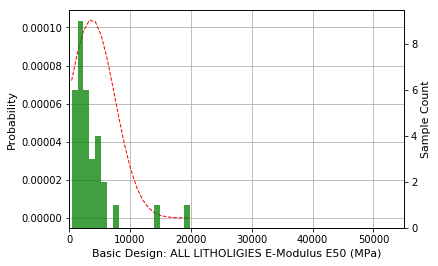

mean = 3707
standard deviation = 3826


In [24]:
# plot histogram of all E50 values
# input: data_E_sel containing 'values' of 'parameter' E
plot_e50(data_E_sel,'Basic Design')

In [25]:
# prepare E50 values from UCS and TX testing for histogram 
# Construction Design

# input: data_E
data_E_sel=[]
select_data(data_E,data_E_sel,'Construction Design')

count for selected E: 47


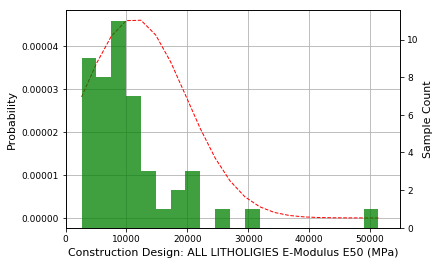

mean = 11229
standard deviation = 8602


In [26]:
# plot histogram of all E50 values
# input: data_E_sel containing 'values' of 'parameter' E
plot_e50(data_E_sel,'Construction Design')

In [64]:
data_E

[{u'borehole_code': u'NT1-1',
  u'lithology': u'Conglomerate',
  u'measurement_convention': u'E50',
  u'sample_code': u'11',
  u'sample_depth_top_m': u'27.10',
  u'sample_description': u'Basic Design',
  u'sample_state': u'',
  u'test_parameters': u'',
  u'test_type': u'E measured during uniaxial compression',
  u'value': u'3352.00',
  u'value_unit': u'MPa'},
 {u'borehole_code': u'NT1-1',
  u'lithology': u'Conglomerate',
  u'measurement_convention': u'E50',
  u'sample_code': u'21',
  u'sample_depth_top_m': u'61.50',
  u'sample_description': u'Basic Design',
  u'sample_state': u'',
  u'test_parameters': u'',
  u'test_type': u'E measured during uniaxial compression',
  u'value': u'3532.00',
  u'value_unit': u'MPa'},
 {u'borehole_code': u'NT1-11',
  u'lithology': u'Grey Sandstone',
  u'measurement_convention': u'E50',
  u'sample_code': u'11',
  u'sample_depth_top_m': u'15.65',
  u'sample_description': u'Basic Design',
  u'sample_state': u'',
  u'test_parameters': u'',
  u'test_type': u'E 

### E50 from UCS laboratory testing

In [28]:
print(dict_E_basic)

{'Fault Gauge SZ2': [], 'Fault Gauge SZ1': [], 'Red Sandstone': [], 'Siltstone': [2017.0, 2669.0, 1902.0, 1413.0], 'Conglomerate': [3352.0, 3532.0, 4895.0], 'Mudstone': [19830.0, 7740.0], 'Grey Sandstone': [3142.0, 14110.0, 3232.0, 2597.0, 4913.0, 4594.0]}


In [29]:
print(dict_E_const)

{'Fault Gauge SZ2': [], 'Fault Gauge SZ1': [], 'Red Sandstone': [13200.0, 51400.0, 19700.0, 17800.0, 22100.0], 'Siltstone': [4170.0, 6760.0, 2790.0, 2630.0, 8180.0, 20700.0, 11400.0, 4290.0, 7780.0, 7450.0, 12000.0, 16800.0, 8680.0, 2980.0, 9300.0, 13200.0, 9140.0, 11900.0, 5650.0, 27000.0, 6050.0], 'Conglomerate': [], 'Mudstone': [], 'Grey Sandstone': [31500.0, 14190.0, 7120.0, 18000.0, 11800.0, 8590.0, 2680.0, 4410.0, 8850.0, 6080.0]}


In [65]:
dict_E_const['Red Sandstone']

[13200.0, 51400.0, 19700.0, 17800.0, 22100.0]

,Lithology,count,mean (MPa),median (MPa),skew,standard deviation (MPa)
0,Red Sandstone,5,24840,19700,1.32,13597
1,Grey Sandstone,10,11322,8720,1.42,8009
2,Siltstone,21,9469,8180,1.34,5970


,Lithology,mean (MPa),standard deviation (MPa),95% CI (MPa)
0,Red Sandstone,24840,13597,2473
1,Grey Sandstone,11322,8009,-1852
2,Siltstone,9469,5970,-352


,Lithology,count,95% CI of mean (MPa),95% CI of std_dev (MPa)
0,Red Sandstone,5,11877,36065
1,Grey Sandstone,10,6680,13888
2,Siltstone,21,7222,8306


,Lithology,mean (MPa),median (MPa),mode (MPa),standard deviation (MPa),95% CI (MPa)
0,Red Sandstone,24505,22088,17947,11771,10439
1,Grey Sandstone,11346,9052,5761,8574,2996
2,Siltstone,9520,7861,5360,6503,2841


,Lithology,count,mean (MPa),median (MPa),skew,standard deviation (MPa)
0,Conglomerate,3,3926,3532,0.67,689
1,Grey Sandstone,6,5431,3913,1.62,3967
2,Siltstone,4,2000,1960,0.27,448
3,Mudstone,2,13785,13785,0.00,6045


,Lithology,mean (MPa),standard deviation (MPa),95% CI (MPa)
0,Conglomerate,3926,689,2793
1,Grey Sandstone,5431,3967,-1094
2,Siltstone,2000,448,1264
3,Mudstone,13785,6045,3841


,Lithology,count,95% CI of mean (MPa),95% CI of std_dev (MPa)
0,Conglomerate,3,2765,3725
1,Grey Sandstone,6,2168,9078
2,Siltstone,4,1473,1510
3,Mudstone,2,-13203,136332


,Lithology,mean (MPa),median (MPa),mode (MPa),standard deviation (MPa),95% CI (MPa)
0,Conglomerate,3925,3870,3763,662,2938
1,Grey Sandstone,5262,4509,3310,3167,1807
2,Siltstone,2001,1950,1853,458,1345
3,Mudstone,13838,12389,9930,6887,5715


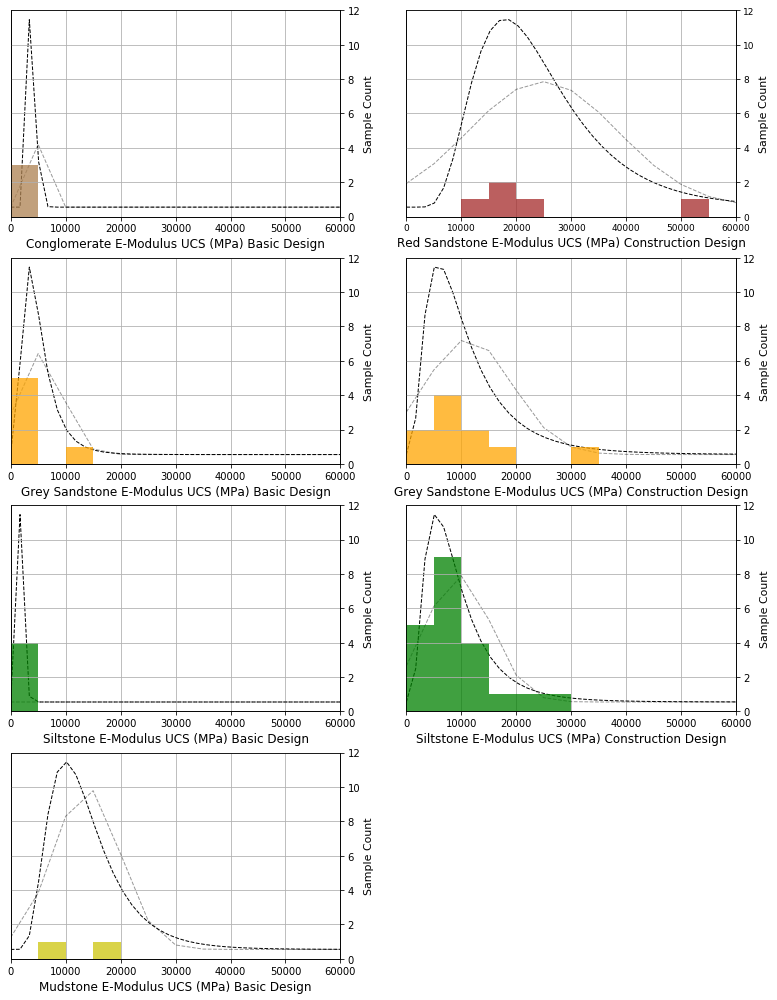

In [30]:
# plot histogram of all E values for selected lithologies 
# input: dict_E_const and dict_E_basic containing 'values' of 'parameter' E 
# adjust: bins,ylim,xlim,xfit,ax1.set_xlabel,display(HTML)

sample_statistics=[]
fitted_norm_dist_parameters=[]
fitted_lognorm_dist_parameters=[]
confidence_limits_norm_dist=[]

def histogram_by_lithology(dict, lithology, sample_description):
    # plot histogram of values for all rock lithologies
    ax2 = ax1.twinx()
    hist,bin_edges,patches = ax2.hist(dict[lithology],bins=[0,5000,10000,15000,20000,25000,30000,35000,40000,
                                                            45000,50000,55000,60000],
                                      normed=0,facecolor=colors[lithology],alpha=0.75)
    ax2.set_ylabel('Sample Count',fontsize=11)
    ax2.set_ylim(0,12)
    ax2.set_xlim(0,60000)

    # plot normal distribution of values using scipy
    param = norm.fit(dict[lithology])  #param[0] and param[1] are mean and standard deviation
    #mean,var = norm.stats(param[0], param[1], moments='mv')  #check
    #ci_90 = norm.interval(0.90, param[0], param[1])  #endpoints of range containing 90 percent of distribution
    y = mlab.normpdf(bin_edges, param[0], param[1])
    ll = ax1.plot(bin_edges, y, 'k--', linewidth=1, alpha=0.4)  #plot pdf
    #ax1.set_ylabel('Probability',fontsize=11)

    # plot lognormal distribution of E values using scipy  #use of lognorm.fit to be checked!             #ToDo JK
    shape, loc, scale = lognorm.fit(dict[lithology],floc=0)  #mu=log(scale), sigma=shape
    # floc=0 -> equivalent to fitting log(data) using stats.norm.fit, e.g. takes care of log transformation
    fitted_lognorm_mean=exp(np.log(scale)+shape**2/2)  #reference: wikipedia.org/wiki/Log-normal_distribution 
    fitted_lognorm_median=scale  #reference as above
    fitted_lognorm_mode=exp(np.log(scale)-shape**2)  #reference as above
    fitted_lognorm_var=(exp(shape**2)-1)*exp(2*np.log(scale)+shape**2)  #reference as above
    lognorm_ci_90 = lognorm.interval(0.90, shape, loc, scale)  #endpoints of range containing 90% of distribution
    fitted_lognorm_fract_5 = lognorm_ci_90[0]  #5% fractile (= lower endpoint of 90% confidence interval)
    x_fit = np.linspace(0,100000,60)
    y = lognorm.pdf(x_fit, shape, loc, scale)
    ll = ax1.plot(x_fit, y, 'k--', linewidth=1)  #plot pdf
    #ax1.set_ylabel('Probability',fontsize=11)

    # sample statistics
    sample_count=len(dict[lithology])  #n
    sample_mean=np.mean(dict[lithology])
    sample_median=np.median(dict[lithology])
    sample_skew=stats.skew(dict[lithology])
    sample_std_dev=np.std(dict[lithology])
    sample_statistics.append((lithology,
                          str(sample_count),
                          str(format(sample_mean,'.0f')),
                          str(format(sample_median,'.0f')),
                          str(format(sample_skew,'.2f')),
                          #str(format(sample_mode,'.0f')),
                          str(format(sample_std_dev,'.0f'))))
    
    # fitted normal distribution parameters
    fitted_norm_mean = param[0]  #mean of fitted distribution
    fitted_norm_std_dev = param[1]  #standard deviation of fitted distribution
    fitted_norm_conf_limit = fitted_norm_mean - fitted_norm_std_dev*1.645  #5% fractile (of 90% confidence interval)
    fitted_norm_dist_parameters.append((lithology,
                       str(format(fitted_norm_mean,'.0f')),  
                       str(format(fitted_norm_std_dev,'.0f')),
                       str(format(fitted_norm_conf_limit,'.0f'))))

    # confidence interval to normal distribution considering sampling
    confidence_limit_t = stats.t.ppf(1-0.05, sample_count-1)  #t-dist one-sided lower 95% confidence limit
    confidence_limit_chi2 = stats.chi2.ppf(0.05,sample_count-1)  #one-sided chi-square upper 95% confidence limit
    confidence_limit_mean = fitted_norm_mean-fitted_norm_std_dev*confidence_limit_t/sqrt(sample_count)
    confidence_limit_std_dev = sqrt(sample_count/confidence_limit_chi2)*fitted_norm_std_dev
    confidence_limits_norm_dist.append((lithology,
                       str(sample_count),  #sample count
                       str(format(confidence_limit_mean,'.0f')),  #95% lower confidence limit of mean
                       str(format(confidence_limit_std_dev,'.0f'))))  #95% upper confidence limit of std_dev

    # fitted lognormal distribution parameters
    fitted_lognorm_dist_parameters.append((lithology,
                        str(format(fitted_lognorm_mean,'.0f')),
                        str(format(fitted_lognorm_median,'.0f')),
                        str(format(fitted_lognorm_mode,'.0f')),                       
                        str(format(sqrt(fitted_lognorm_var),'.0f')),  #standard deviation
                        str(format(fitted_lognorm_fract_5,'.0f'))))  #95% confidence interval

    #print('mean: '+str(format(np.mean(dict[lithology]),'.0f'))+
    #      '   median: '+str(format(np.median(dict[lithology]),'.0f'))+
    #      '   mode: '+str(format(float(mode(dict[lithology])[0]),'.0f'))+
    #      '   std_dev: '+str(format(np.std(dict[lithology]),'.0f')))
    #print('count: '+str(sample_count)+'   CL_mean: '+str(format(confidence_limit_mean,'.0f'))+
    #      '   CL_std_dev: '+str(format(confidence_limit_std_dev,'.0f')))

    # plot axis labels and grid
    ax1.set_xlabel(lithology+' E-Modulus UCS (MPa) '+sample_description,fontsize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)  
    ax1.axes.get_yaxis().set_ticks([])  #supress pdf lables on left y-axis
    ax1.grid(True); ax2.grid(True)

# report sample statistics
def report_sample_statistics(project_phase):  #
    sample_statistics_df = pd.DataFrame(data=sample_statistics)
    sample_statistics_df.columns = [u'Lithology', u'count', u'mean (MPa)', u'median (MPa)', u'skew',
                                    u'standard deviation (MPa)']
    display(HTML('<h4>Sample statistics of E values - '
                 +project_phase+'</h3>'))
    display(HTML(sample_statistics_df.to_html()))

# report fitted normal distribution parameters
def report_fitted_norm_dist_parameters(project_phase):  #fitted_norm_dist_parameters
    fitted_norm_dist_parameters_df = pd.DataFrame(data=fitted_norm_dist_parameters)
    fitted_norm_dist_parameters_df.columns = [u'Lithology', u'mean (MPa)', u'standard deviation (MPa)', 
                                              u'95% CI (MPa)']
    display(HTML('<h4>Parameters of normal distribution fitted to sampled E values - '
                 +project_phase+'</h3>'))
    display(HTML(fitted_norm_dist_parameters_df.to_html(
                 formatters={'mean (MPa)':lambda x: '<strong>%s</strong>' %x},escape=False)))

# report confidence intervals considering sampling
def report_confidence_limits_norm_dist(project_phase):  #
    confidence_limits_norm_dist_df = pd.DataFrame(data=confidence_limits_norm_dist)
    confidence_limits_norm_dist_df.columns = [u'Lithology', u'count', 
                                    u'95% CI of mean (MPa)', u'95% CI of std_dev (MPa)']
    display(HTML('<h4>Confidence intervals of testing against normal distribution of E values - '
                 +project_phase+'</h3>'))
    display(HTML(confidence_limits_norm_dist_df.to_html(
                 formatters={'count':lambda x: '<strong>%s</strong>' %x,
                             '95% CI of mean (MPa)':lambda x: '<strong>%s</strong>' %x},escape=False)))

def report_fitted_lognorm_dist_parameters(project_phase):
    fitted_lognorm_dist_parameters_df = pd.DataFrame(data=fitted_lognorm_dist_parameters)
    fitted_lognorm_dist_parameters_df.columns = [u'Lithology', u'mean (MPa)', u'median (MPa)', u'mode (MPa)', 
                                                 u'standard deviation (MPa)', u'95% CI (MPa)']
    display(HTML('<h4>Parameters of lognormal distribution fitted to sampled E values - '
                 +project_phase+'</h3>'))
    display(HTML(fitted_lognorm_dist_parameters_df.to_html()))


fig = plt.figure(figsize=(13,22))
ax1 = fig.add_subplot(5, 2, 2)  #4 rows, 3 columns, 2nd position
histogram_by_lithology(dict_E_const, 'Red Sandstone', 'Construction Design')
ax1 = fig.add_subplot(5, 2, 4)
histogram_by_lithology(dict_E_const, 'Grey Sandstone', 'Construction Design')
ax1 = fig.add_subplot(5, 2, 6)
histogram_by_lithology(dict_E_const, 'Siltstone', 'Construction Design')
# ax1 = fig.add_subplot(5, 2, 8)
# histogram_by_lithology(dict_E_const, 'Mudstone', 'Construction Design')
report_sample_statistics('Construction Design')
report_fitted_norm_dist_parameters('Construction Design')
report_confidence_limits_norm_dist('Construction Design')
report_fitted_lognorm_dist_parameters('Construction Design')

sample_statistics=[]
fitted_norm_dist_parameters=[]
confidence_limits_norm_dist=[]
fitted_lognorm_dist_parameters=[]
ax1 = fig.add_subplot(5, 2, 1)
histogram_by_lithology(dict_E_basic, 'Conglomerate', 'Basic Design')
ax1 = fig.add_subplot(5, 2, 3)
histogram_by_lithology(dict_E_basic, 'Grey Sandstone', 'Basic Design')
ax1 = fig.add_subplot(5, 2, 5)
histogram_by_lithology(dict_E_basic, 'Siltstone', 'Basic Design')
ax1 = fig.add_subplot(5, 2, 7)
histogram_by_lithology(dict_E_basic, 'Mudstone', 'Basic Design')

report_sample_statistics('Basic Design')
report_fitted_norm_dist_parameters('Basic Design')
report_confidence_limits_norm_dist('Basic Design')
report_fitted_lognorm_dist_parameters('Basic Design')
plt.show()
##fig.canvas.draw()

Dry and soaked samples are considered together in histograms.

In [31]:
print stats.t.ppf(1-0.05, 13-1)  #one-sided lower 95% confidence interval

1.782287555649159


In [32]:
print stats.chi2.ppf(0.05,26)  #95% one-sided upper confidence limit

15.37915658326173


### E from field testing

In [33]:
# prepare E values for selected lithologies 
# input: data_E

dict_E_field_basic={}

# rework as loops over project_phases and lithologies                                               #ToDo JK

select_by_lithology(data_E_field, 'Red Sandstone', dict_E_field_basic, 'Basic Design')
select_by_lithology(data_E_field, 'Grey Sandstone', dict_E_field_basic, 'Basic Design')
select_by_lithology(data_E_field, 'Siltstone', dict_E_field_basic, 'Basic Design')
select_by_lithology(data_E_field, 'Mudstone', dict_E_field_basic, 'Basic Design')
select_by_lithology(data_E_field, 'Conglomerate', dict_E_field_basic, 'Basic Design')
select_by_lithology(data_E_field, 'Fault Gauge SZ1', dict_E_field_basic, 'Basic Design')
select_by_lithology(data_E_field, 'Fault Gauge SZ2', dict_E_field_basic, 'Basic Design')

#print(dict_E_field_basic)

In [34]:
print(dict_E_field_basic)

{'Fault Gauge SZ2': [], 'Fault Gauge SZ1': [], 'Red Sandstone': [], 'Siltstone': [3560.0, 3450.0, 2880.0, 2580.0, 3430.0, 3160.0, 4060.0, 3770.0, 2700.0, 3450.0, 3830.0, 3620.0, 2880.0, 3760.0, 4020.0, 3900.0, 3760.0, 3270.0, 4140.0, 2850.0], 'Conglomerate': [3200.0, 3370.0, 1800.0], 'Mudstone': [], 'Grey Sandstone': [1820.0, 3390.0, 4910.0, 2330.0, 5100.0, 4070.0, 4180.0, 880.0, 2020.0, 3840.0, 3200.0, 2150.0, 4620.0, 3250.0, 4780.0, 2950.0, 3970.0, 6740.0, 773.0, 4230.0, 7490.0, 6040.0, 6790.0, 6450.0, 5030.0, 7590.0, 7760.0, 7240.0, 6460.0, 4470.0, 5410.0, 5780.0, 1320.0, 1590.0, 1850.0, 1150.0, 2130.0]}


In [35]:
def histogram_by_lithology2(dict, lithology, sample_description):
    # plot histogram of values for all rock lithologies
    ax2 = ax1.twinx()
    hist,bin_edges,patches = ax2.hist(dict[lithology],bins=[0,5000,10000,15000,20000,25000,30000,35000,40000,
                                                            45000,50000,55000,60000],
                                      normed=0,facecolor=colors[lithology],alpha=0.75)
    ax2.set_ylabel('Sample Count',fontsize=11)
    ax2.set_ylim(0,30)
    ax2.set_xlim(0,60000)

    # plot normal distribution of values using scipy
    param = norm.fit(dict[lithology])  #param[0] and param[1] are mean and standard deviation
    #mean,var = norm.stats(param[0], param[1], moments='mv')  #check
    #ci_90 = norm.interval(0.90, param[0], param[1])  #endpoints of range containing 90 percent of distribution
    y = mlab.normpdf(bin_edges, param[0], param[1])
    ll = ax1.plot(bin_edges, y, 'k--', linewidth=1, alpha=0.4)  #plot pdf
    #ax1.set_ylabel('Probability',fontsize=11)

    # plot lognormal distribution of E values using scipy  #use of lognorm.fit to be checked!             #ToDo JK
    shape, loc, scale = lognorm.fit(dict[lithology],floc=0)  #mu=log(scale), sigma=shape
    # floc=0 -> equivalent to fitting log(data) using stats.norm.fit, e.g. takes care of log transformation
    fitted_lognorm_mean=exp(np.log(scale)+shape**2/2)  #reference: wikipedia.org/wiki/Log-normal_distribution 
    fitted_lognorm_median=scale  #reference as above
    fitted_lognorm_mode=exp(np.log(scale)-shape**2)  #reference as above
    fitted_lognorm_var=(exp(shape**2)-1)*exp(2*np.log(scale)+shape**2)  #reference as above
    lognorm_ci_90 = lognorm.interval(0.90, shape, loc, scale)  #endpoints of range containing 90% of distribution
    fitted_lognorm_fract_5 = lognorm_ci_90[0]  #5% fractile (= lower endpoint of 90% confidence interval)
    x_fit = np.linspace(0,100000,60)
    y = lognorm.pdf(x_fit, shape, loc, scale)
    ll = ax1.plot(x_fit, y, 'k--', linewidth=1)  #plot pdf
    #ax1.set_ylabel('Probability',fontsize=11)

    # sample statistics
    sample_count=len(dict[lithology])  #n
    sample_mean=np.mean(dict[lithology])
    sample_median=np.median(dict[lithology])
    sample_skew=stats.skew(dict[lithology])
    sample_std_dev=np.std(dict[lithology])
    sample_statistics.append((lithology,
                          str(sample_count),
                          str(format(sample_mean,'.0f')),
                          str(format(sample_median,'.0f')),
                          str(format(sample_skew,'.2f')),
                          #str(format(sample_mode,'.0f')),
                          str(format(sample_std_dev,'.0f'))))
    
    # fitted normal distribution parameters
    fitted_norm_mean = param[0]  #mean of fitted distribution
    fitted_norm_std_dev = param[1]  #standard deviation of fitted distribution
    fitted_norm_conf_limit = fitted_norm_mean - fitted_norm_std_dev*1.645  #5% fractile (of 90% confidence interval)
    fitted_norm_dist_parameters.append((lithology,
                       str(format(fitted_norm_mean,'.0f')),  
                       str(format(fitted_norm_std_dev,'.0f')),
                       str(format(fitted_norm_conf_limit,'.0f'))))

    # confidence interval to normal distribution considering sampling
    confidence_limit_t = stats.t.ppf(1-0.05, sample_count-1)  #t-dist one-sided lower 95% confidence limit
    confidence_limit_chi2 = stats.chi2.ppf(0.05,sample_count-1)  #one-sided chi-square upper 95% confidence limit
    confidence_limit_mean = fitted_norm_mean-fitted_norm_std_dev*confidence_limit_t/sqrt(sample_count)
    confidence_limit_std_dev = sqrt(sample_count/confidence_limit_chi2)*fitted_norm_std_dev
    confidence_limits_norm_dist.append((lithology,
                       str(sample_count),  #sample count
                       str(format(confidence_limit_mean,'.0f')),  #95% lower confidence limit of mean
                       str(format(confidence_limit_std_dev,'.0f'))))  #95% upper confidence limit of std_dev

    # fitted lognormal distribution parameters
    fitted_lognorm_dist_parameters.append((lithology,
                        str(format(fitted_lognorm_mean,'.0f')),
                        str(format(fitted_lognorm_median,'.0f')),
                        str(format(fitted_lognorm_mode,'.0f')),                       
                        str(format(sqrt(fitted_lognorm_var),'.0f')),  #standard deviation
                        str(format(fitted_lognorm_fract_5,'.0f'))))  #95% confidence interval

    # plot axis labels and grid
    ax1.set_xlabel(lithology+' E-Modulus UCS (MPa) '+sample_description,fontsize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)  
    ax1.axes.get_yaxis().set_ticks([])  #supress pdf lables on left y-axis
    ax1.grid(True); ax2.grid(True)

,Lithology,count,mean (MPa),median (MPa),skew,standard deviation (MPa)
0,Conglomerate,3,2790,3200,-0.68,703
1,Grey Sandstone,37,4155,4180,0.08,2059
2,Siltstone,20,3454,3505,-0.38,464


,Lithology,mean (MPa),standard deviation (MPa),95% CI (MPa)
0,Conglomerate,2790,703,1633
1,Grey Sandstone,4155,2059,769
2,Siltstone,3454,464,2691


,Lithology,count,95% CI of mean (MPa),95% CI of std_dev (MPa)
0,Conglomerate,3,1604,3804
1,Grey Sandstone,37,3584,2596
2,Siltstone,20,3274,652


,Lithology,mean (MPa),median (MPa),mode (MPa),standard deviation (MPa),95% CI (MPa)
0,Conglomerate,2798,2688,2479,812,1684
1,Grey Sandstone,4286,3535,2404,2939,1273
2,Siltstone,3454,3421,3355,485,2718


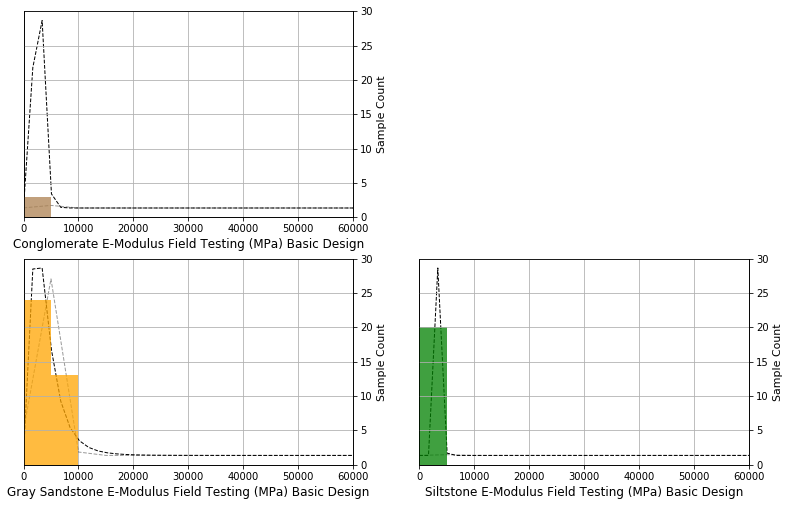

In [36]:
# plot histogram of all E values for selected lithologies 
# input: dict_E_const and dict_E_basic containing 'values' of 'parameter' E 
# adjust: bins,ylim,xlim,xfit,ax1.set_xlabel,display(HTML)

sample_statistics=[]
fitted_norm_dist_parameters=[]
fitted_lognorm_dist_parameters=[]
confidence_limits_norm_dist=[]

# required functions are already defined
fig = plt.figure(figsize=(13,22))
sample_statistics=[]
fitted_norm_dist_parameters=[]
confidence_limits_norm_dist=[]
fitted_lognorm_dist_parameters=[]

ax1 = fig.add_subplot(5, 2, 1)
histogram_by_lithology2(dict_E_field_basic, 'Conglomerate', 'Basic Design')
ax1.set_xlabel('Conglomerate E-Modulus Field Testing (MPa) Basic Design',fontsize=12)

ax1 = fig.add_subplot(5, 2, 3)
histogram_by_lithology2(dict_E_field_basic, 'Grey Sandstone', 'Basic Design')
ax1.set_xlabel('Gray Sandstone E-Modulus Field Testing (MPa) Basic Design',fontsize=12)

ax1 = fig.add_subplot(5, 2, 4)
histogram_by_lithology2(dict_E_field_basic, 'Siltstone', 'Basic Design')
ax1.set_xlabel('Siltstone E-Modulus Field Testing (MPa) Basic Design',fontsize=12)

report_sample_statistics('Basic Design')
report_fitted_norm_dist_parameters('Basic Design')
report_confidence_limits_norm_dist('Basic Design')
report_fitted_lognorm_dist_parameters('Basic Design')
plt.show()
##fig.canvas.draw()

### Compressive strength sigma_c from UCS laboratory testing

In [37]:
len(data_sigma_c)

92

In [38]:
# prepare sigma_c (uniaxial compression) values for a selected lithologies
# input: data_sigma_c

dict_sigma_c_basic={}
dict_sigma_c_const={}

# select sigma_c data from uniaxial compression testing
data_sigma_c_sel=[]

# select testing results for Uniaxial compression
for item in data_sigma_c:
    # correction due to uppercase in Compression in data sheet
    #if (item['test_type']) == 'Uniaxial compression' or (item['test_type']) == 'Uniaxial Compression':
    #use this for all conditionals against data                                                     #ToDo JK
    if (item['test_type'].lower()) == 'uniaxial compression':  
        data_sigma_c_sel.append(item)
print(len(data_sigma_c_sel))

# simplify with for loops                                                                                 #ToDo JK
select_by_lithology(data_sigma_c_sel, 'Red Sandstone', dict_sigma_c_const, 'Construction Design')
select_by_lithology(data_sigma_c_sel, 'Grey Sandstone', dict_sigma_c_const, 'Construction Design')
select_by_lithology(data_sigma_c_sel, 'Siltstone', dict_sigma_c_const, 'Construction Design')
select_by_lithology(data_sigma_c_sel, 'Mudstone', dict_sigma_c_const, 'Construction Design')
select_by_lithology(data_sigma_c_sel, 'Conglomerate', dict_sigma_c_const, 'Construction Design')
select_by_lithology(data_sigma_c_sel, 'Fault Gauge SZ1', dict_sigma_c_const, 'Construction Design')
select_by_lithology(data_sigma_c_sel, 'Fault Gauge SZ2', dict_sigma_c_const, 'Construction Design')

select_by_lithology(data_sigma_c_sel, 'Red Sandstone', dict_sigma_c_basic, 'Basic Design')
select_by_lithology(data_sigma_c_sel, 'Grey Sandstone', dict_sigma_c_basic, 'Basic Design')
select_by_lithology(data_sigma_c_sel, 'Siltstone', dict_sigma_c_basic, 'Basic Design')
select_by_lithology(data_sigma_c_sel, 'Mudstone', dict_sigma_c_basic, 'Basic Design')
select_by_lithology(data_sigma_c_sel, 'Conglomerate', dict_sigma_c_basic, 'Basic Design')
select_by_lithology(data_sigma_c_sel, 'Fault Gauge SZ1', dict_sigma_c_basic, 'Basic Design')
select_by_lithology(data_sigma_c_sel, 'Fault Gauge SZ2', dict_sigma_c_basic, 'Basic Design')

print(dict_sigma_c_basic)
print(dict_sigma_c_const)
print(len(dict_sigma_c_const['Red Sandstone']))
print(len(dict_sigma_c_const['Siltstone']))
print(len(dict_sigma_c_basic['Grey Sandstone']))
print(len(dict_sigma_c_basic['Siltstone']))
print(len(dict_sigma_c_basic['Conglomerate']))

57
{'Fault Gauge SZ2': [], 'Fault Gauge SZ1': [], 'Red Sandstone': [], 'Siltstone': [44.02, 11.11, 13.79, 53.64, 19.97, 29.78, 7.55], 'Conglomerate': [86.82, 75.15, 113.55], 'Mudstone': [7.0, 25.6], 'Grey Sandstone': [85.02, 18.39, 83.3, 56.94, 58.69, 19.45, 122.15, 118.97]}
{'Fault Gauge SZ2': [], 'Fault Gauge SZ1': [], 'Red Sandstone': [56.01, 106.68, 126.68, 78.68, 105.35], 'Siltstone': [20.67, 22.04, 19.98, 17.98, 23.58, 36.06, 19.29, 8.46, 9.77, 28.93, 28.93, 56.97, 47.41, 45.9, 50.75, 46.33, 40.88, 39.38, 19.13, 24.67, 15.3, 17.21], 'Conglomerate': [], 'Mudstone': [], 'Grey Sandstone': [110.22, 82.39, 41.33, 94.75, 68.89, 64.75, 19.29, 28.65, 41.2, 35.47]}
5
22
8
7
3


,Lithology,count,mean (MPa),median (MPa),skew,standard deviation (MPa)
0,Red Sandstone,5,95,105,-0.35,25
1,Siltstone,22,29,24,0.45,14
2,Grey Sandstone,10,59,53,0.37,29


,Lithology,mean (MPa),standard deviation (MPa),95% CI (MPa)
0,Red Sandstone,95,25,54
1,Siltstone,29,14,6
2,Grey Sandstone,59,29,11


,Lithology,count,95% CI of mean (MPa),95% CI of std_dev (MPa)
0,Red Sandstone,5,71,65
1,Siltstone,22,24,19
2,Grey Sandstone,10,42,50


,Lithology,mean (MPa),median (MPa),mode (MPa),standard deviation (MPa),95% CI (MPa)
0,Red Sandstone,95,91,84,28,57
1,Siltstone,29,26,20,16,11
2,Grey Sandstone,59,51,39,34,21


,Lithology,count,mean (MPa),median (MPa),skew,standard deviation (MPa)
0,Conglomerate,3,92,87,0.44,16
1,Grey Sandstone,8,70,71,-0.04,37
2,Siltstone,7,26,20,0.57,16
3,Mudstone,2,16,16,0.00,9


,Lithology,mean (MPa),standard deviation (MPa),95% CI (MPa)
0,Conglomerate,92,16,65
1,Grey Sandstone,70,37,9
2,Siltstone,26,16,-1
3,Mudstone,16,9,1


,Lithology,count,95% CI of mean (MPa),95% CI of std_dev (MPa)
0,Conglomerate,3,65,87
1,Grey Sandstone,8,45,71
2,Siltstone,7,14,34
3,Mudstone,2,-25,210


,Lithology,mean (MPa),median (MPa),mode (MPa),standard deviation (MPa),95% CI (MPa)
0,Conglomerate,92,90,88,16,68
1,Grey Sandstone,73,58,36,58,18
2,Siltstone,26,21,13,20,7
3,Mudstone,17,13,9,12,5


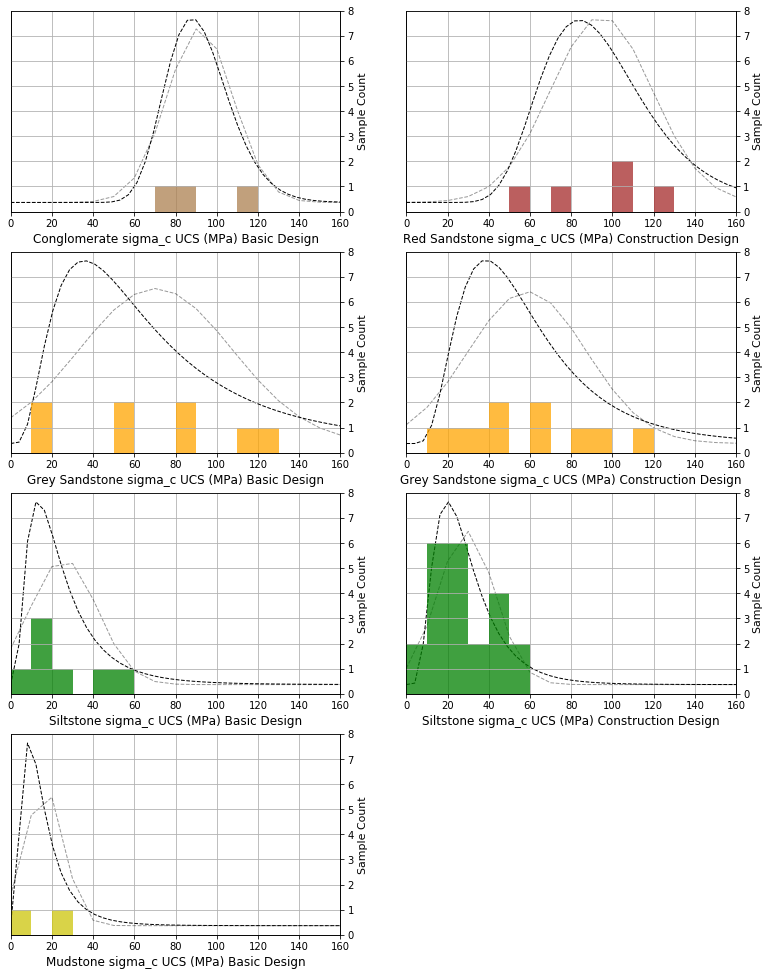

In [39]:
# plot histogram of all sigma_c values for selected lithologies 
# input: dict_sigma_c_const, dict_sigma_c_basic containing 'values' of 'parameter' sigma_c
# adjust: bins,ylim,xlim,xfit,ax1.set_xlabel,display(HTML)

sample_statistics=[]
fitted_norm_dist_parameters=[]
fitted_lognorm_dist_parameters=[]
confidence_limits_norm_dist=[]
    
def histogram_by_lithology(dict, lithology, sample_description):
    # plot histogram for values of selected lithology 
    ax2 = ax1.twinx()
    hist,bin_edges,patches = ax2.hist(dict[lithology],
                                      bins=[0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160],
                                      normed=0,facecolor=colors[lithology],alpha=0.75)
    ax2.set_ylabel('Sample Count',fontsize=11)
    ax2.set_ylim(0,8)
    ax2.set_xlim(0,160)

    # plot normal distribution of values using scipy
    param = norm.fit(dict[lithology])  #param[0] and param[1] are mean and standard deviation
    y = mlab.normpdf( bin_edges, param[0], param[1])
    ll = ax1.plot(bin_edges, y, 'k--', linewidth=1, alpha=0.4)  #plot pdf
    #ax1.set_ylabel('Probability',fontsize=11)

    # plot lognormal distribution of E values using scipy  #use of lognorm.fit to be checked!             #ToDo JK
    shape, loc, scale = lognorm.fit(dict[lithology],floc=0)  #mu=log(scale), sigma=shape
    # floc=0 -> equivalent to fitting log(data) using stats.norm.fit, e.g. takes care of log transformation
    fitted_lognorm_mean=exp(np.log(scale)+shape**2/2)  #reference: wikipedia.org/wiki/Log-normal_distribution 
    fitted_lognorm_median=scale  #reference as above
    fitted_lognorm_mode=exp(np.log(scale)-shape**2)  #reference as above
    fitted_lognorm_var=(exp(shape**2)-1)*exp(2*np.log(scale)+shape**2)  #reference as above
    lognorm_ci_90 = lognorm.interval(0.90, shape, loc, scale)  #endpoints of range containing 90% of distribution
    fitted_lognorm_fract_5 = lognorm_ci_90[0]  #5% fractile (= lower endpoint of 90% confidence interval)
    x_fit = np.linspace(0,200,50)
    y = lognorm.pdf(x_fit, shape, loc, scale)
    ll = ax1.plot(x_fit, y, 'k--', linewidth=1)  #plot pdf
    #ax1.set_ylabel('Probability',fontsize=11)

    # sample statistics
    sample_count=len(dict[lithology])  #n
    sample_mean=np.mean(dict[lithology])
    sample_median=np.median(dict[lithology])
    sample_skew=stats.skew(dict[lithology])
    sample_std_dev=np.std(dict[lithology])
    sample_statistics.append((lithology,
                          str(sample_count),
                          str(format(sample_mean,'.0f')),
                          str(format(sample_median,'.0f')),
                          str(format(sample_skew,'.2f')),
                          #str(format(sample_mode,'.0f')),
                          str(format(sample_std_dev,'.0f'))))
    
    # fitted normal distribution parameters
    fitted_norm_mean = param[0]  #mean of fitted distribution
    fitted_norm_std_dev = param[1]  #standard deviation of fitted distribution
    fitted_norm_conf_limit = fitted_norm_mean - fitted_norm_std_dev*1.645  #5% fractile (of 90% confidence interval)
    fitted_norm_dist_parameters.append((lithology,
                       str(format(fitted_norm_mean,'.0f')),  
                       str(format(fitted_norm_std_dev,'.0f')),
                       str(format(fitted_norm_conf_limit,'.0f'))))

    # confidence interval to normal distribution considering sampling
    confidence_limit_t = stats.t.ppf(1-0.05, sample_count-1)  #t-dist one-sided lower 95% confidence limit
    confidence_limit_chi2 = stats.chi2.ppf(0.05,sample_count-1)  #one-sided chi-square upper 95% confidence limit
    confidence_limit_mean = fitted_norm_mean-fitted_norm_std_dev*confidence_limit_t/sqrt(sample_count)
    confidence_limit_std_dev = sqrt(sample_count/confidence_limit_chi2)*fitted_norm_std_dev
    confidence_limits_norm_dist.append((lithology,
                       str(sample_count),  #sample count
                       str(format(confidence_limit_mean,'.0f')),  #95% lower confidence limit of mean
                       str(format(confidence_limit_std_dev,'.0f'))))  #95% upper confidence limit of std_dev

    # fitted lognormal distribution parameters
    fitted_lognorm_dist_parameters.append((lithology,
                        str(format(fitted_lognorm_mean,'.0f')),
                        str(format(fitted_lognorm_median,'.0f')),
                        str(format(fitted_lognorm_mode,'.0f')),                       
                        str(format(sqrt(fitted_lognorm_var),'.0f')),  #standard deviation
                        str(format(fitted_lognorm_fract_5,'.0f'))))  #95% confidence interval
    
    # plot axis labels and grid
    ax1.set_xlabel(lithology+' sigma_c UCS (MPa) '+sample_description,fontsize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)  
    ax1.axes.get_yaxis().set_ticks([])  #supress pdf lables on left y-axis
    ax1.grid(True); ax2.grid(True)

# report sample statistics
def report_sample_statistics(project_phase):  #
    sample_statistics_df = pd.DataFrame(data=sample_statistics)
    sample_statistics_df.columns = [u'Lithology', u'count', u'mean (MPa)', u'median (MPa)', u'skew',
                                    u'standard deviation (MPa)']
    display(HTML('<h4>Sample statistics of sigma_c values - '
                 +project_phase+'</h3>'))
    display(HTML(sample_statistics_df.to_html()))

# report fitted normal distribution parameters
def report_fitted_norm_dist_parameters(project_phase):  #fitted_norm_dist_parameters
    fitted_norm_dist_parameters_df = pd.DataFrame(data=fitted_norm_dist_parameters)
    fitted_norm_dist_parameters_df.columns = [u'Lithology', u'mean (MPa)', u'standard deviation (MPa)', 
                                              u'95% CI (MPa)']
    display(HTML('<h4>Parameters of normal distribution fitted to sampled sigma_c values - '
                 +project_phase+'</h3>'))
    display(HTML(fitted_norm_dist_parameters_df.to_html(
                 formatters={'mean (MPa)':lambda x: '<strong>%s</strong>' %x},escape=False)))

# report confidence intervals considering sampling
def report_confidence_limits_norm_dist(project_phase):  #
    confidence_limits_norm_dist_df = pd.DataFrame(data=confidence_limits_norm_dist)
    confidence_limits_norm_dist_df.columns = [u'Lithology', u'count', 
                                    u'95% CI of mean (MPa)', u'95% CI of std_dev (MPa)']
    display(HTML('<h4>Confidence intervals of testing against normal distribution of sigma_c values - '
                 +project_phase+'</h3>'))
    display(HTML(confidence_limits_norm_dist_df.to_html(
                 formatters={'count':lambda x: '<strong>%s</strong>' %x,
                             '95% CI of mean (MPa)':lambda x: '<strong>%s</strong>' %x},escape=False)))

def report_fitted_lognorm_dist_parameters(project_phase):
    fitted_lognorm_dist_parameters_df = pd.DataFrame(data=fitted_lognorm_dist_parameters)
    fitted_lognorm_dist_parameters_df.columns = [u'Lithology', u'mean (MPa)', u'median (MPa)', u'mode (MPa)', 
                                                 u'standard deviation (MPa)', u'95% CI (MPa)']
    display(HTML('<h4>Parameters of lognormal distribution fitted to sampled sigma_c values - '
                 +project_phase+'</h3>'))
    display(HTML(fitted_lognorm_dist_parameters_df.to_html()))


fig = plt.figure(figsize=(13,17))
ax1 = fig.add_subplot(4, 2, 2)
histogram_by_lithology(dict_sigma_c_const, 'Red Sandstone', 'Construction Design')
ax1 = fig.add_subplot(4, 2, 6)
histogram_by_lithology(dict_sigma_c_const, 'Siltstone', 'Construction Design')
ax1 = fig.add_subplot(4, 2, 4)
histogram_by_lithology(dict_sigma_c_const, 'Grey Sandstone', 'Construction Design')
report_sample_statistics('Construction Design')
report_fitted_norm_dist_parameters('Construction Design')
report_confidence_limits_norm_dist('Construction Design')
report_fitted_lognorm_dist_parameters('Construction Design')

sample_statistics=[]
fitted_norm_dist_parameters=[]
confidence_limits_norm_dist=[]
fitted_lognorm_dist_parameters=[]
ax1 = fig.add_subplot(4, 2, 1)
histogram_by_lithology(dict_sigma_c_basic, 'Conglomerate', 'Basic Design')
ax1 = fig.add_subplot(4, 2, 3)
histogram_by_lithology(dict_sigma_c_basic, 'Grey Sandstone', 'Basic Design')
ax1 = fig.add_subplot(4, 2, 5)
histogram_by_lithology(dict_sigma_c_basic, 'Siltstone', 'Basic Design')
ax1 = fig.add_subplot(4, 2, 7)
histogram_by_lithology(dict_sigma_c_basic, 'Mudstone', 'Basic Design')
report_sample_statistics('Basic Design')
report_fitted_norm_dist_parameters('Basic Design')
report_confidence_limits_norm_dist('Basic Design')
report_fitted_lognorm_dist_parameters('Basic Design')
plt.show()

Dry and soaked samples are considered together in histograms.

## p-q plot from sigma_c and tau data from triaxial testing

In [40]:
# select sigma_c (uniaxial and triaxial compression) and tau (direct shear) values for selected lithologies
# these values also used for the sigma_1 vs sigma_3 plots

# sample_desciption is used to store construction phase (phase hould be added to parameter metadata) #ToDo JK 
tests={'ucs':data_sigma_c,'tx':data_sigma_c,'ds':data_tau}  #test types and input data for each test type
#test_names={'ucs':'Uniaxial compression','tx':'Triaxial compression','ds':'Direct shear'}  #for selecting test_type
# upper or lower case names in test_types are allowed in selected_strengths()
test_names={'ucs':'uniaxial compression','tx':'triaxial compression','ds':'direct shear'}
# lithologies - should be defined only one time, used for all routines                               #ToDo JK
lithologies=('Red Sandstone','Grey Sandstone','Siltstone','Conglomerate','Mudstone',
             'Fault Gauge SZ1','Fault Gauge SZ2')
sig1_const = {'ucs': {}, 'tx': {}, 'ds': {}}; sig3_const = {'ucs': {}, 'tx': {}, 'ds': {}}  #dictionaries
sig1_basic = {'ucs': {}, 'tx': {}, 'ds': {}}; sig3_basic = {'ucs': {}, 'tx': {}, 'ds': {}}  #dictionaries
# allow for additional marker on plots
sig3_const_m = {'ucs': {}, 'tx': {}, 'ds': {}}; sig3_basic_m = {'ucs': {}, 'tx': {}, 'ds': {}}

selected_strengths('Construction Design', sig1_const, sig3_const, sig3_const_m) 
selected_strengths('Basic Design', sig1_basic, sig3_basic, sig3_basic_m)            

def count_selected_strengths(sig1,description):  #counts for data checking
    for item in sig1:
        count=0
        for lithology,value in sig1[item].items():
            item_len = len(sig1[item][lithology])
            count = count + item_len
            if item_len > 1:
                print(description+':   count for selected '+str(item)+' in '+str(lithology)+': '+str(item_len))
        print (description+': count for selected '+str(item)+': '+str(count)) 

count_selected_strengths(sig1_const,'Construction Design')
count_selected_strengths(sig1_basic,'Basic Design')

#print sig1_const['ucs']['Siltstone']
#print sig1_const['tx']
#print sig3_const['tx']

Construction Design:   count for selected ucs in Red Sandstone: 5
Construction Design:   count for selected ucs in Siltstone: 22
Construction Design:   count for selected ucs in Grey Sandstone: 10
Construction Design: count for selected ucs: 37
Construction Design:   count for selected ds in Fault Gauge SZ2: 24
Construction Design:   count for selected ds in Fault Gauge SZ1: 12
Construction Design:   count for selected ds in Red Sandstone: 12
Construction Design:   count for selected ds in Siltstone: 6
Construction Design:   count for selected ds in Grey Sandstone: 18
Construction Design: count for selected ds: 72
Construction Design:   count for selected tx in Red Sandstone: 6
Construction Design:   count for selected tx in Siltstone: 11
Construction Design: count for selected tx: 17
Basic Design:   count for selected ucs in Siltstone: 7
Basic Design:   count for selected ucs in Conglomerate: 3
Basic Design:   count for selected ucs in Mudstone: 2
Basic Design:   count for selected uc

slope: 0.8988808238409681    intercept: 2.235866675534538
phi: 64.0113442601    c: 5.102467972258814
(0.8988808238409681, 0.04467180687106447)
slope: 0.8278527660801578    intercept: 2.330257999552476
phi: 55.8787928562    c: 4.154161514684525
(0.8278527660801578, 0.06730791309565441)


,Lithology,cohesion (MPa),phi (deg),phi[95%CI-],phi[95%CI+],std_err,correlation,p_value
0,Red Sandstone,5.102,64.0,55.6,76.5,0.04,1.00,0.00004
1,Siltstone,4.154,55.9,45.8,69.8,0.07,0.97,0.00000


slope: 0.9829476102318009    intercept: -1.914288553783571
phi: 79.4038196698    c: -10.410202008864541
(0.9829476102318009, 0.018823061012866026)
slope: 0.984275448436323    intercept: -1.6231839695629375
phi: 79.8258648358    c: -9.189198458669633
(0.984275448436323, 0.06357304480709917)


,Lithology,cohesion (MPa),phi (deg),phi[95%CI-],phi[95%CI+],std_err,correlation,p_value
0,Grey Sandstone,-10.410,79.4,72.2,90.0,0.02,1.00,0.00000
1,Siltstone,-9.189,79.8,61.6,90.0,0.06,0.98,0.00000


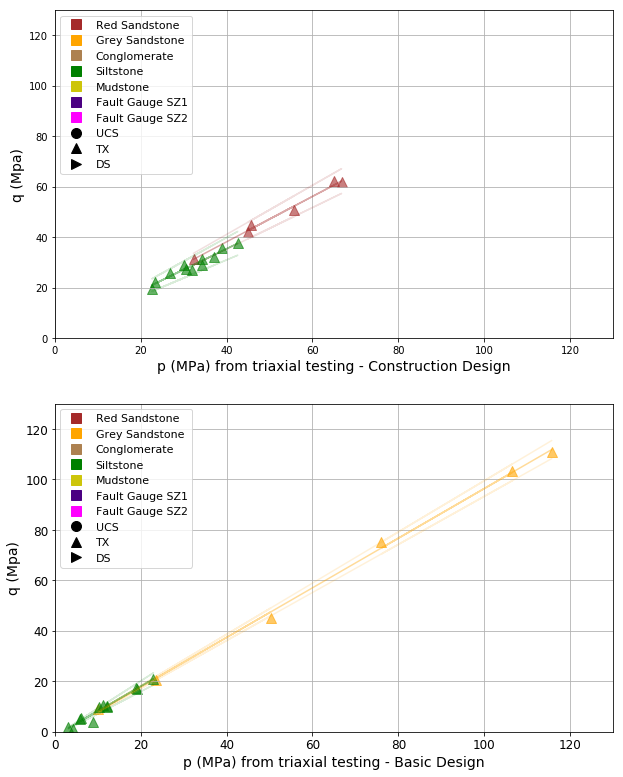

In [41]:
# p-q plot for sigma_c and tau data for all rock lithologies                                          
# input: sig1..., sig3... containing 'values' of 'parameter' and 'test_parameters'

statistics=[]

def pq_plot(sig1, sig3, lithology, test, sample_description):
# p-q plot for values of selected lithology
    sig1_ = np.array(sig1[lithology])
    sig3_ = np.array(sig3[lithology])
    line=(); s1=(); s3=()
    intercept=0.; slope=0.; std_err=0.
    #statistics=[]
    #if test=='ucs' or test=='tx':
    if test=='ucs':
        plt.scatter(((sig1_ + sig3_)/2.),((sig1_ - sig3_)/2.),
                    marker=markers[test],s= 100.,facecolor=colors[lithology],alpha=0.6)
        if sig1_.any() and test=='tx':  #mv test for any above plt.scatter?                          #ToDo JK
            s1=(sig1_ + sig3_)/2.
            s3=(sig1_ - sig3_)/2.
            slope, intercept, r_value, p_value, std_err = stats.linregress(s1,s3)
            line = slope*s1+intercept
        plt.plot(s1,line, color=colors[lithology],alpha=0.4)
        #print(test+':  '+lithology+'  '+'intercept: '+str(intercept)+'  slope: '+str(slope)+'  error: '+str(std_err))

    if test=='tx':
        plt.scatter(((sig1_ + sig3_)/2.),((sig1_ - sig3_)/2.),
                    marker=markers[test],s= 100.,facecolor=colors[lithology],alpha=0.6)
        if sig1_.any() and test=='tx':  #mv test for any above plt.scatter?                               #ToDo JK
            s1=(sig1_ + sig3_)/2.
            s3=(sig1_ - sig3_)/2.
            slope, intercept, r_value, p_value, std_err = stats.linregress(s1,s3)
            line = slope*s1+intercept            
            line_upper = (slope+std_err*1.645)*s1+intercept
            line_lower = (slope-std_err*1.645)*s1+intercept
                                    
            #calculate c and phi from intercept and slope (a and alpha in p-q space) of trend lines
            print('slope: '+str(slope)+'    intercept: '+str(intercept))
            phi=asin(slope) #slope=tan(alpha)
            c=intercept/cos(phi)
            print('phi: '+str(degrees(phi))+'    c: '+str(c))
            
            print(slope, std_err) 
            statistics.append((lithology,
                              str(format(c,'.3f')),
                              str(format(degrees(phi),'.1f')),
                              str(format(degrees(asin(slope-std_err*1.645)),'.1f')),
                              # check for slope+std_err >1 and limit to 1 max. -> limiting phi to 90 deg max
                              str(format(degrees(asin(min(1, slope+std_err*1.645))),'.1f')),  
                              str(format(std_err,'.2f')),
                              str(format(r_value,'.2f')),str(format(p_value,'.5f'))))
            
            plt.plot(s1,line, color=colors[lithology],alpha=0.4)
            plt.plot(s1,line_upper, color=colors[lithology],alpha=0.15)
            plt.plot(s1,line_lower, color=colors[lithology],alpha=0.15)            
            #print(test+':  '+lithology+'  '+'intercept: '+str(intercept)+'  slope: '+str(slope)+'  error: '+str(std_err))
        
    if test=='ds':
        plt.scatter(rand_jitter(sig3_),rand_jitter(sig1_),
                    marker=markers[test],s= 150.,facecolor=colors[lithology],alpha=0.6)
        if not sig1_.any():  #if no data for lithology  --> mv this above plt.scatter                      #ToDo JK
            pass
        else:
            slope, intercept, r_value, p_value, std_err = stats.linregress(sig3_,sig1_)
            line = slope*sig3_+intercept             
        plt.plot(sig3_,line, color=colors[lithology],alpha=0.4)
        #print(test+':  '+lithology+'  '+'intercept: '+str(intercept)+'  slope: '+str(slope)+'  error: '+str(std_err))

    plt.ylabel('q (Mpa)',fontsize=14)
    #plt.xlabel('p (MPa) '+sample_description,fontsize=14)
    plt.xlabel('p (MPa) from triaxial testing - '+sample_description,fontsize=14)
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=12)
    plt.grid(True)

# display derived parameters and statistics
def plot_statistics(project_phase):
    statistics_df = pd.DataFrame(data=statistics)
    statistics_df.columns = [u'Lithology', u'cohesion (MPa)', u'phi (deg)', u'phi[95%CI-]', u'phi[95%CI+]', 
                             u'std_err', u'correlation', u'p_value']
    display(HTML('<h4>Derived c, phi and statistics of plotted p-q values from triaxial testing - '
                 +project_phase+'</h3>'))
    display(HTML(statistics_df.to_html()))
    

plt.figure(figsize=(10, 35))

#plt.subplot(511)
#plt.xlim((0,70))
#plt.ylim((0,70))
#for lithology in lithologies:
#    pq_plot(sig1_const['ucs'], sig3_const['ucs'],lithology,'ucs','Construction Design')
##for lithology in lithologies:
##    pq_plot(sig1_const['tx'], sig3_const['tx'],lithology,'tx','Construction Design')
#legend()

plt.subplot(511)
plt.xlim((0,130))
plt.ylim((0,130))
for lithology in lithologies:
    pq_plot(sig1_const['tx'], sig3_const['tx'],lithology,'tx','Construction Design')
legend_for_litholgies_tests("upper left")
plot_statistics('Construction Design')

#plt.subplot(513)
#plt.xlim((0,70))
#plt.ylim((0,70))
#for lithology in lithologies:
#    pq_plot(sig1_basic['ucs'], sig3_basic['ucs'],lithology,'ucs','Basic Design')
##for lithology in lithologies:
##    pq_plot(sig1_basic['tx'], sig3_basic['tx'],lithology,'tx','Basic Design')
#legend()

plt.subplot(512)
plt.xlim((0,130))
plt.ylim((0,130))
statistics=[]  #set list for HTML table to null
for lithology in lithologies:
    pq_plot(sig1_basic['tx'], sig3_basic['tx'],lithology,'tx','Basic Design')
legend_for_litholgies_tests("upper left")
plot_statistics('Basic Design')

#plt.subplot(515)
#plt.xlim((0,3))
#plt.ylim((0,3))
#for lithology in lithologies:
#    pq_plot(sig1_const['ds'], sig3_const['ds'],lithology,'ds','Construction Design') 
#plt.ylabel('tau (Mpa)',fontsize=14)
#plt.xlabel('sigma_v (MPa) Construction Design',fontsize=14)
#legend()    

plt.show()

In [42]:
slope = 0.9829476102318009
std_err = 0.018823061012866026
#degrees(asin(slope+std_err*1.645))
#asin(slope+std_err*1.645)
(slope+std_err*1.645)

1.0139115455979655

## sigma_1 and sigma_3 data from triaxial testing

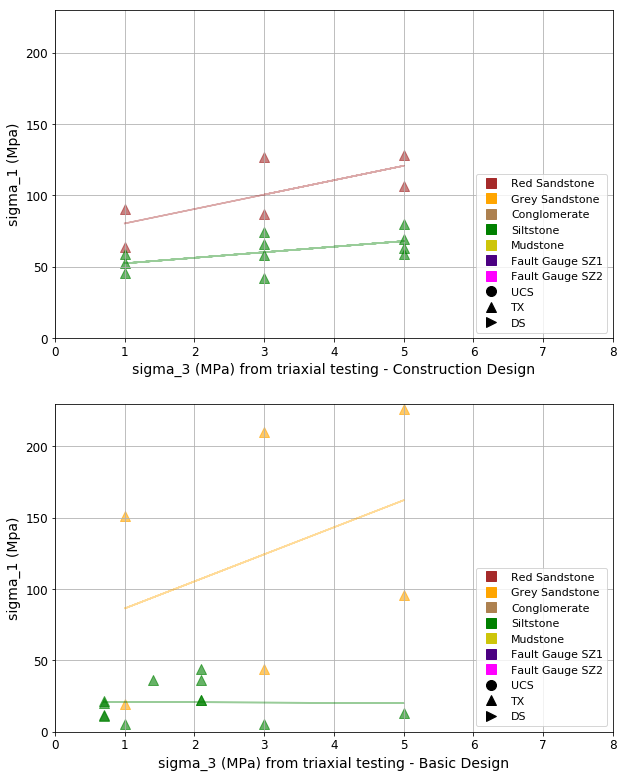

In [43]:
# sig1 vs sig3 plot for TX sigma_c data for all rock lithologies                                          
# show different plots for basic and construction design                                                    ToDo JK
# input: sig1..., sig3... containing 'values' of 'parameter' and 'test_parameters'
# ADJUST: project phases, lithologies (above), plots: xlimit, ylimit, legend

def s1s3_plot(sig1, sig3, lithology, test, sample_description):
# sig1-sig3 plot for values of selected lithology
    sig1_ = np.array(sig1[lithology])
    sig3_ = np.array(sig3[lithology])
    line=(); s1=(); s3=()
    intercept=0.; slope=0.; std_err=0.

    if test=='tx':
        plt.scatter(sig3_, sig1_,
                    marker=markers[test],s= 100.,facecolor=colors[lithology],alpha=0.6)
        if sig1_.any() and test=='tx':  #mv test for any above plt.scatter?                               #ToDo JK
            s1=sig1_
            s3=sig3_
            slope, intercept, r_value, p_value, std_err = stats.linregress(s3,s1)
            line = slope*s3+intercept
        plt.plot(s3,line, color=colors[lithology],alpha=0.4)
        #print(test+':  '+lithology+'  '+'intercept: '+str(intercept)+'  slope: '+str(slope)+'  error: '+str(std_err))
        
    plt.ylabel('sigma_1 (Mpa)',fontsize=14)
    #plt.xlabel('p (MPa) '+sample_description,fontsize=14)
    plt.xlabel('sigma_3 (MPa) from triaxial testing - '+sample_description,fontsize=14)
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=12)
    plt.grid(True)

plt.figure(figsize=(10, 35))

#plt.subplot(511)
#plt.xlim((0,70))
#plt.ylim((0,70))
#for lithology in lithologies:
#    s1s3_plot(sig1_const['ucs'], sig3_const['ucs'],lithology,'ucs','Construction Design')
##for lithology in lithologies:
##    s1s3_plot(sig1_const['tx'], sig3_const['tx'],lithology,'tx','Construction Design')
#legend()

plt.subplot(511)
plt.xlim((0,8))
plt.ylim((0,230))
for lithology in lithologies:
    s1s3_plot(sig1_const['tx'], sig3_const['tx'],lithology,'tx','Construction Design')
legend_for_litholgies_tests("lower right")

#plt.subplot(513)
#plt.xlim((0,70))
#plt.ylim((0,70))
#for lithology in lithologies:
#    s1s3_plot(sig1_basic['ucs'], sig3_basic['ucs'],lithology,'ucs','Basic Design')
##for lithology in lithologies:
##    s1s3_plot(sig1_basic['tx'], sig3_basic['tx'],lithology,'tx','Basic Design')
#legend()

plt.subplot(512)
plt.xlim((0,8))
plt.ylim((0,230))
for lithology in lithologies:
    s1s3_plot(sig1_basic['tx'], sig3_basic['tx'],lithology,'tx','Basic Design')
legend_for_litholgies_tests("lower right")
#plt.subplot(515)
#plt.xlim((0,3))
#plt.ylim((0,3))
#for lithology in lithologies:
#    s1s3_plot(sig1_const['ds'], sig3_const['ds'],lithology,'ds','Construction Design') 
#plt.ylabel('tau (Mpa)',fontsize=14)
#plt.xlabel('sigma_v (MPa) Construction Design',fontsize=14)
#legend()    

plt.show()

## sigma_1 and sigma_3 data from uniaxial and triaxial testing considered together

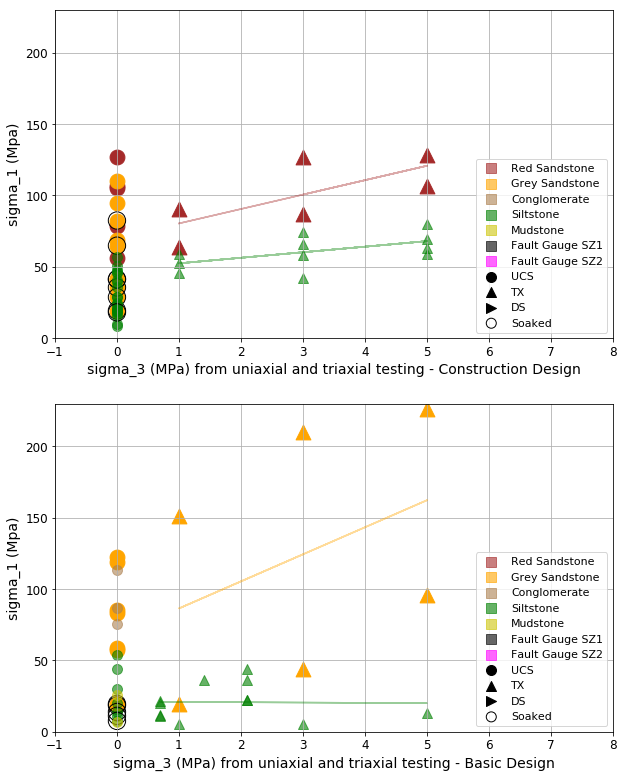

In [44]:
# sig1 vs sig3 plot for UCS and TX sigma_c data for all rock lithologies
# show different plots for basic and construction design                                                    ToDo JK
# input: sig1..., sig3... containing 'values' of 'parameter' and 'test_parameters'
# ADJUST: project phases, lithologies (above), plots: xlimit, ylimit, legend

def s1s3_plot(sig1, sig3, lithology, test, sample_description):
# sig1-sig3 plot for values of selected lithology
    sig1_ = np.array(sig1[lithology])
    sig3_ = np.array(sig3[lithology])
    line=(); s1=(); s3=()
    intercept=0.; slope=0.; std_err=0.
#     if test=='ucs' or test=='tx':
#         plt.scatter(sig3_, sig1_,
#                     marker=markers[test],s= 100.,facecolor=colors[lithology],alpha=0.6)
#         if sig1_.any() and test=='tx':  #mv test for any above plt.scatter?                          #ToDo JK
#             s1=sig1_
#             s3=sig3_
#             slope, intercept, r_value, p_value, std_err = stats.linregress(s3,s1)
#             line = slope*s3+intercept
#         plt.plot(s3,line, color=colors[lithology],alpha=0.4)
#         #print(test+':  '+lithology+'  '+'intercept: '+str(intercept)+'  slope: '+str(slope)+'  error: '+str(std_err))

# highlight Grey Sandstone in plot (size s, alpha) to avoid being hidden by Siltstones
    if test=='ucs' or test=='tx':
        if lithology == 'Grey Sandstone' or lithology == 'Red Sandstone':
            plt.scatter(sig3_, sig1_,
                    marker=markers[test],s= 220.,facecolor=colors[lithology],alpha=1.0)
        else:             plt.scatter(sig3_, sig1_,
                    marker=markers[test],s= 100.,facecolor=colors[lithology],alpha=0.6)

        if sig1_.any() and test=='tx':  #mv test for any above plt.scatter?                          #ToDo JK
            s1=sig1_
            s3=sig3_
            slope, intercept, r_value, p_value, std_err = stats.linregress(s3,s1)
            line = slope*s3+intercept
        plt.plot(s3,line, color=colors[lithology],alpha=0.4)
        #print(test+':  '+lithology+'  '+'intercept: '+str(intercept)+'  slope: '+str(slope)+'  error: '+str(std_err))
        
    plt.ylabel('sigma_1 (Mpa)',fontsize=14)
    #plt.xlabel('p (MPa) '+sample_description,fontsize=14)
    plt.xlabel('sigma_3 (MPa) from uniaxial and triaxial testing - '+sample_description,fontsize=14)
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=12)
    plt.grid(True)

# plot markers showing sample_state (e.g. 'Soaked')        
def plot_marker(marker, y, x):
    for i in range(len(x)):
        if (marker[i]) == 'Soaked':
            plt.scatter(x[i], y[i],
                    marker='o',s= 300.,edgecolor='black',facecolor='',alpha=1.0)
            #print(marker[i],x[i],y[i])
          
      
plt.figure(figsize=(10, 35))

plt.subplot(511)
plt.xlim((-1,8))
plt.ylim((0,230))
for lithology in lithologies:
    s1s3_plot(sig1_const['ucs'], sig3_const['ucs'],lithology,'ucs','Construction Design')
    plot_marker(np.array(sig3_const_m['ucs'][lithology]),np.array(sig1_const['ucs'][lithology]),
                np.array(sig3_const['ucs'][lithology]))    
        
for lithology in lithologies:    
    s1s3_plot(sig1_const['tx'], sig3_const['tx'],lithology,'tx','Construction Design')    
    plot_marker(np.array(sig3_const_m['tx'][lithology]),np.array(sig1_const['tx'][lithology]),
                np.array(sig3_const['tx'][lithology]))    
#for lithology in lithologies:
legend_for_litholgies_tests_2("lower right")

plt.subplot(512)
plt.xlim((-1,8))
plt.ylim((0,230))
for lithology in lithologies:
    s1s3_plot(sig1_basic['ucs'], sig3_basic['ucs'],lithology,'ucs','Basic Design')
    plot_marker(np.array(sig3_basic_m['ucs'][lithology]),np.array(sig1_basic['ucs'][lithology]),
                np.array(sig3_basic['ucs'][lithology]))    
        
for lithology in lithologies:
    s1s3_plot(sig1_basic['tx'], sig3_basic['tx'],lithology,'tx','Basic Design')
    plot_marker(np.array(sig3_basic_m['tx'][lithology]),np.array(sig1_basic['tx'][lithology]),
                np.array(sig3_basic['tx'][lithology]))    
legend_for_litholgies_tests_2("lower right")

plt.show()

In [45]:
np.array(sig1_const['ucs']['Siltstone'])

array([20.67, 22.04, 19.98, 17.98, 23.58, 36.06, 19.29,  8.46,  9.77,
       28.93, 28.93, 56.97, 47.41, 45.9 , 50.75, 46.33, 40.88, 39.38,
       19.13, 24.67, 15.3 , 17.21])

## sigma_v and tau data from direct shear testing

### peak strength

In [46]:
# query Data Organizer records for 'parameter' = tau
# sorting by borehole_code and sample_depth

# initialize variables
data_tau=[]

parameter = 'tau'
fields = ['borehole_code','sample_description','lithology', 'sample_depth_top_m', 
          'value', 'value_unit', 'measurement_convention', 'test_parameters', 'test_type']
selector = {'project_code': 'NT1.r8','data_source': 'Laboratory'}
sort = ['borehole_code','sample_depth_top_m']

# write selected fields to lists
# reduce 'test_parameter' to show only value of first parameter
for rec in db.get_parameter(parameter, fields, selector, sort):
    try:
      type(float(rec['value']))         
    except:
      rec['value'] = 'NaN'
    
    rec['test_parameters'] = rec['test_parameters'][0]['value']  #Fix -should write to new key e.g. s3    #ToDo JK

    if rec['measurement_convention'] == 'Peak strength':  #tmp - should handled in plot data              #ToDo JK
      data_tau.append(rec)
    
print('count for tau: '+str(len(data_tau)))    # record count for checking

count for tau: 84


In [47]:
# select sigma_c (uniaxial and triaxial compression) and tau (direct shear) values for selected lithologies

# sample_desciption is used to store construction phase (phase hould be added to parameter metadata)       #ToDo JK 
tests={'ucs':data_sigma_c,'tx':data_sigma_c,'ds':data_tau}  #test types and input data for each test type
#test_names={'ucs':'Uniaxial compression','tx':'Triaxial compression','ds':'Direct shear'}  #for selecting test_type
# upper or lower case names in test_types are allowed in selected_strengths()
test_names={'ucs':'uniaxial compression','tx':'triaxial compression','ds':'direct shear'}
lithologies=('Red Sandstone','Grey Sandstone','Siltstone','Conglomerate','Mudstone',
             'Fault Gauge SZ1','Fault Gauge SZ2')
sig1_const = {'ucs': {}, 'tx': {}, 'ds': {}}; sig3_const = {'ucs': {}, 'tx': {}, 'ds': {}}  #dictionaries
sig1_basic = {'ucs': {}, 'tx': {}, 'ds': {}}; sig3_basic = {'ucs': {}, 'tx': {}, 'ds': {}}  #dictionaries
# allow for additional marker on plots
sig3_const_m = {'ucs': {}, 'tx': {}, 'ds': {}}; sig3_basic_m = {'ucs': {}, 'tx': {}, 'ds': {}}
                                
selected_strengths('Construction Design', sig1_const, sig3_const, sig3_const_m) 
selected_strengths('Basic Design', sig1_basic, sig3_basic, sig3_basic_m)            

def count_selected_strengths(sig1,description):  #counts for data checking
    for item in sig1: 
        count=0
        for lithology,value in sig1[item].items():
            item_len = len(sig1[item][lithology])
            count = count + item_len
            if item_len > 1:
                print(description+':   count for selected '+str(item)+' in '+str(lithology)+': '+str(item_len))
        print (description+': count for selected '+str(item)+': '+str(count)) 

count_selected_strengths(sig1_const,'Construction Design')
count_selected_strengths(sig1_basic,'Basic Design')

#print sig1_const['ucs']['Siltstone']
#print sig1_const['tx']
#print sig3_const['tx']

Construction Design:   count for selected ucs in Red Sandstone: 5
Construction Design:   count for selected ucs in Siltstone: 22
Construction Design:   count for selected ucs in Grey Sandstone: 10
Construction Design: count for selected ucs: 37
Construction Design:   count for selected ds in Fault Gauge SZ2: 12
Construction Design:   count for selected ds in Fault Gauge SZ1: 6
Construction Design:   count for selected ds in Red Sandstone: 12
Construction Design:   count for selected ds in Siltstone: 6
Construction Design:   count for selected ds in Grey Sandstone: 18
Construction Design: count for selected ds: 54
Construction Design:   count for selected tx in Red Sandstone: 6
Construction Design:   count for selected tx in Siltstone: 11
Construction Design: count for selected tx: 17
Basic Design:   count for selected ucs in Siltstone: 7
Basic Design:   count for selected ucs in Conglomerate: 3
Basic Design:   count for selected ucs in Mudstone: 2
Basic Design:   count for selected ucs

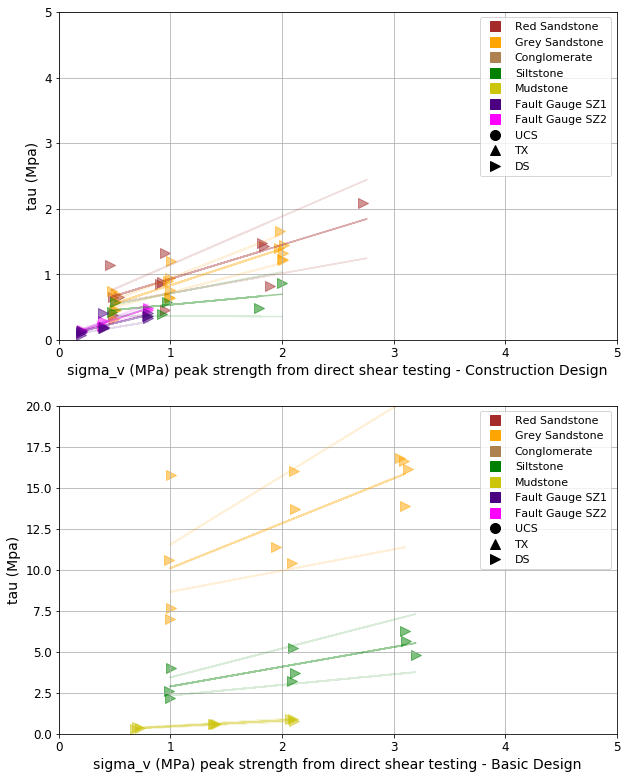

In [48]:
# Direct Shear plot for sigma_c and tau data for all rock lithologies                                          
# show different plots for basic and construction design                                                    ToDo JK
# input: sig1..., sig3... containing 'values' of 'parameter' and 'test_parameters'

statistics=[]

def pq_plot(sig1, sig3, lithology, test, sample_description):
# p-q plot for values of selected lithology
    sig1_ = np.array(sig1[lithology])
    sig3_ = np.array(sig3[lithology])
    line=(); s1=(); s3=()
    intercept=0.; slope=0.; std_err=0.
    #if test=='ucs' or test=='tx':
    if test=='ucs':
        plt.scatter(((sig1_ + sig3_)/2.),((sig1_ - sig3_)/2.),
                    marker=markers[test],s= 100.,facecolor=colors[lithology],alpha=0.6)
        if sig1_.any() and test=='tx':  #mv test for any above plt.scatter?                               #ToDo JK
            s1=(sig1_ + sig3_)/2.
            s3=(sig1_ - sig3_)/2.
            slope, intercept, r_value, p_value, std_err = stats.linregress(s1,s3)
            line = slope*s1+intercept
        plt.plot(s1,line, color=colors[lithology],alpha=0.4)
        #print(test+':  '+lithology+'  '+'intercept: '+str(intercept)+'  slope: '+str(slope)+'  error: '+str(std_err))

    if test=='tx':
        plt.scatter(((sig1_ + sig3_)/2.),((sig1_ - sig3_)/2.),
                    marker=markers[test],s= 100.,facecolor=colors[lithology],alpha=0.6)
        if sig1_.any() and test=='tx':  #mv test for any above plt.scatter?                               #ToDo JK
            s1=(sig1_ + sig3_)/2.
            s3=(sig1_ - sig3_)/2.
            slope, intercept, r_value, p_value, std_err = stats.linregress(s1,s3)
            line = slope*s1+intercept
        plt.plot(s1,line, color=colors[lithology],alpha=0.4)
        #print(test+':  '+lithology+'  '+'intercept: '+str(intercept)+'  slope: '+str(slope)+'  error: '+str(std_err))
        
    if test=='ds':
        plt.scatter(rand_jitter(sig3_),rand_jitter(sig1_),
                    marker=markers[test],s= 100.,facecolor=colors[lithology],alpha=0.5)
        if not sig1_.any():  #if no data for lithology  --> mv this above plt.scatter                      #ToDo JK
            pass
        else:
            slope, intercept, r_value, p_value, std_err = stats.linregress(sig3_,sig1_)
            line = slope*sig3_+intercept            
            line_upper = (slope+std_err*1.645)*sig3_+intercept
            line_lower = (slope-std_err*1.645)*sig3_+intercept
            plt.plot(sig3_,line, color=colors[lithology],alpha=0.4)
            plt.plot(sig3_,line_upper, color=colors[lithology],alpha=0.15)
            plt.plot(sig3_,line_lower, color=colors[lithology],alpha=0.15)
            #print(test+':  '+lithology+'  '+'intercept: '+str(intercept)+'  slope: '+str(slope)+'  error: '+str(std_err))

            statistics.append((lithology,
                              str(format(intercept,'.3f')),
                              str(format(degrees(atan(slope)),'.1f')),
                              str(format(degrees(atan(slope-std_err*1.645)),'.1f')),
                              str(format(degrees(atan(slope+std_err*1.645)),'.1f')),
                              str(format(std_err,'.2f')),
                              str(format(r_value,'.2f')),str(format(p_value,'.5f'))))
            
    plt.ylabel('q (Mpa)',fontsize=14)
    #plt.xlabel('p (MPa) '+sample_description,fontsize=14)
    plt.xlabel('p (MPa) from triaxial testing - '+sample_description,fontsize=14)
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=12)
    plt.grid(True)

plt.figure(figsize=(10, 35))

plt.subplot(511)
plt.xlim((0,5))
plt.ylim((0,5))
for lithology in lithologies:
    pq_plot(sig1_const['ds'], sig3_const['ds'],lithology,'ds','Construction Design') 
plt.ylabel('tau (Mpa)',fontsize=14)
plt.xlabel('sigma_v (MPa) peak strength from direct shear testing - Construction Design',fontsize=14)
legend_for_litholgies_tests("upper right")
statistics_ConstDes = statistics

statistics=[]
plt.subplot(512)
plt.xlim((0,5))
plt.ylim((0,20))
for lithology in lithologies:
    pq_plot(sig1_basic['ds'], sig3_basic['ds'],lithology,'ds','Basic Design') 
plt.ylabel('tau (Mpa)',fontsize=14)
plt.xlabel('sigma_v (MPa) peak strength from direct shear testing - Basic Design',fontsize=14)
legend_for_litholgies_tests("upper right")
statistics_BasicDes = statistics

plt.show()

In [49]:
# display derived parameters and statistics
statistics_df = pd.DataFrame(data=statistics_ConstDes)
statistics_df.columns = [u'Lithology', u'cohesion (MPa)', u'phi (deg)', u'phi[95%CI-]', u'phi[95%CI+]', 
                         u'std_err', u'correlation', u'p_value']
display(HTML('<h4>c, phi statistics of from direct shear testing - peak strength - Construction Design</h4>'))
display(HTML(statistics_df.to_html()))  

,Lithology,cohesion (MPa),phi (deg),phi[95%CI-],phi[95%CI+],std_err,correlation,p_value
0,Red Sandstone,0.411,27.4,16.8,36.4,0.13,0.78,0.00277
1,Grey Sandstone,0.277,29.1,24.1,33.7,0.07,0.90,0.00000
2,Siltstone,0.377,9.1,-0.6,18.3,0.10,0.61,0.19694
3,Fault Gauge SZ1,0.028,29.5,26.0,32.8,0.05,0.99,0.00030
4,Fault Gauge SZ2,0.050,22.5,15.8,28.6,0.08,0.85,0.00042


In [50]:
# display derived parameters and statistics
statistics_df = pd.DataFrame(data=statistics_BasicDes)
statistics_df.columns = [u'Lithology', u'cohesion (MPa)', u'phi (deg)', u'phi[95%CI-]', u'phi[95%CI+]', 
                         u'std_err', u'correlation', u'p_value']
display(HTML('<h4>c, phi statistics from direct shear testing - peak strength - Basic Design</h3>'))
display(HTML(statistics_df.to_html()))  

,Lithology,cohesion (MPa),phi (deg),phi[95%CI-],phi[95%CI+],std_err,correlation,p_value
0,Grey Sandstone,7.353,69.9,52.3,76.5,0.88,0.70,0.01084
1,Siltstone,1.677,50.2,32.9,60.3,0.34,0.80,0.00911
2,Mudstone,0.086,19.8,17.7,21.8,0.02,0.98,0.00000


### residual strength

In [51]:
# query Data Organizer records for 'parameter' = tau
# sorting by borehole_code and sample_depth

# initialize variables
data_tau=[]

parameter = 'tau'
fields = ['borehole_code','sample_description','lithology', 'sample_depth_top_m', 
          'value', 'value_unit', 'measurement_convention', 'test_parameters', 'test_type']
selector = {'project_code': 'NT1.r8','data_source': 'Laboratory'}
sort = ['borehole_code','sample_depth_top_m']

# write selected fields to lists
# reduce 'test_parameter' to show only value of first parameter
for rec in db.get_parameter(parameter, fields, selector, sort):
    try:
      type(float(rec['value']))         
    except:
      rec['value'] = 'NaN'
    
    rec['test_parameters'] = rec['test_parameters'][0]['value']  #Fix -should write to new key e.g. s3    #ToDo JK

    if rec['measurement_convention'] == 'Residual strength':  #tmp - should handled in plot data              #ToDo JK
      data_tau.append(rec)
    
print('count for tau: '+str(len(data_tau)))    # record count for checking

count for tau: 39


In [52]:
# select sigma_c (uniaxial and triaxial compression) and tau (direct shear) values for selected lithologies

# sample_desciption is used to store construction phase (phase hould be added to parameter metadata)       #ToDo JK 
tests={'ucs':data_sigma_c,'tx':data_sigma_c,'ds':data_tau}  #test types and input data for each test type
#test_names={'ucs':'Uniaxial compression','tx':'Triaxial compression','ds':'Direct shear'}  #for selecting test_type
# upper or lower case names in test_types are allowed in selected_strengths()
test_names={'ucs':'uniaxial compression','tx':'triaxial compression','ds':'direct shear'}
lithologies=('Red Sandstone','Grey Sandstone','Siltstone','Conglomerate','Mudstone',
             'Fault Gauge SZ1','Fault Gauge SZ2')
sig1_const = {'ucs': {}, 'tx': {}, 'ds': {}}; sig3_const = {'ucs': {}, 'tx': {}, 'ds': {}}  #dictionaries
sig1_basic = {'ucs': {}, 'tx': {}, 'ds': {}}; sig3_basic = {'ucs': {}, 'tx': {}, 'ds': {}}  #dictionaries
# allow for additional marker on plots
sig3_const_m = {'ucs': {}, 'tx': {}, 'ds': {}}; sig3_basic_m = {'ucs': {}, 'tx': {}, 'ds': {}}

selected_strengths('Construction Design', sig1_const, sig3_const, sig3_const_m) 
selected_strengths('Basic Design', sig1_basic, sig3_basic, sig3_basic_m)            

def count_selected_strengths(sig1,description):  #counts for data checking
    for item in sig1: 
        count=0
        for lithology,value in sig1[item].items():
            item_len = len(sig1[item][lithology])
            count = count + item_len
            if item_len > 1:
                print(description+':   count for selected '+str(item)+' in '+str(lithology)+': '+str(item_len))
        print (description+': count for selected '+str(item)+': '+str(count)) 

count_selected_strengths(sig1_const,'Construction Design')
count_selected_strengths(sig1_basic,'Basic Design')

#print sig1_const['ucs']['Siltstone']
#print sig1_const['tx']
#print sig3_const['tx']

Construction Design:   count for selected ucs in Red Sandstone: 5
Construction Design:   count for selected ucs in Siltstone: 22
Construction Design:   count for selected ucs in Grey Sandstone: 10
Construction Design: count for selected ucs: 37
Construction Design:   count for selected ds in Fault Gauge SZ2: 12
Construction Design:   count for selected ds in Fault Gauge SZ1: 6
Construction Design: count for selected ds: 18
Construction Design:   count for selected tx in Red Sandstone: 6
Construction Design:   count for selected tx in Siltstone: 11
Construction Design: count for selected tx: 17
Basic Design:   count for selected ucs in Siltstone: 7
Basic Design:   count for selected ucs in Conglomerate: 3
Basic Design:   count for selected ucs in Mudstone: 2
Basic Design:   count for selected ucs in Grey Sandstone: 8
Basic Design: count for selected ucs: 20
Basic Design:   count for selected ds in Siltstone: 9
Basic Design:   count for selected ds in Grey Sandstone: 12
Basic Design: cou

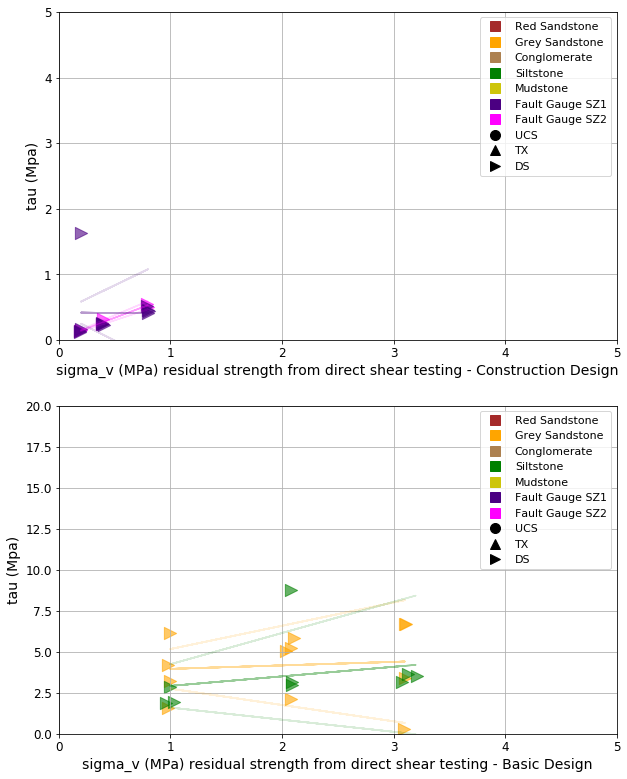

In [53]:
# Direct Shear plot for sigma_c and tau data for all rock lithologies                                          
# show different plots for basic and construction design                                                    ToDo JK
# input: sig1..., sig3... containing 'values' of 'parameter' and 'test_parameters'

statistics=[]

def pq_plot(sig1, sig3, lithology, test, sample_description):
# p-q plot for values of selected lithology
    sig1_ = np.array(sig1[lithology])
    sig3_ = np.array(sig3[lithology])
    line=(); s1=(); s3=()
    intercept=0.; slope=0.; std_err=0.
    #if test=='ucs' or test=='tx':
    if test=='ucs':
        plt.scatter(((sig1_ + sig3_)/2.),((sig1_ - sig3_)/2.),
                    marker=markers[test],s= 100.,facecolor=colors[lithology],alpha=0.6)
        if sig1_.any() and test=='tx':  #mv test for any above plt.scatter?                               #ToDo JK
            s1=(sig1_ + sig3_)/2.
            s3=(sig1_ - sig3_)/2.
            slope, intercept, r_value, p_value, std_err = stats.linregress(s1,s3)
            line = slope*s1+intercept
        plt.plot(s1,line, color=colors[lithology],alpha=0.4)
        #print(test+':  '+lithology+'  '+'intercept: '+str(intercept)+'  slope: '+str(slope)+'  error: '+str(std_err))

    if test=='tx':
        plt.scatter(((sig1_ + sig3_)/2.),((sig1_ - sig3_)/2.),
                    marker=markers[test],s= 100.,facecolor=colors[lithology],alpha=0.6)
        if sig1_.any() and test=='tx':  #mv test for any above plt.scatter?                               #ToDo JK
            s1=(sig1_ + sig3_)/2.
            s3=(sig1_ - sig3_)/2.
            slope, intercept, r_value, p_value, std_err = stats.linregress(s1,s3)
            line = slope*s1+intercept
        plt.plot(s1,line, color=colors[lithology],alpha=0.4)
        #print(test+':  '+lithology+'  '+'intercept: '+str(intercept)+'  slope: '+str(slope)+'  error: '+str(std_err))
        
    if test=='ds':
        plt.scatter(rand_jitter(sig3_),rand_jitter(sig1_),
                    marker=markers[test],s= 150.,facecolor=colors[lithology],alpha=0.6)
        if not sig1_.any():  #if no data for lithology  --> mv this above plt.scatter                #ToDo JK
            pass
        else:
            slope, intercept, r_value, p_value, std_err = stats.linregress(sig3_,sig1_)
            line = slope*sig3_+intercept
            line_upper = (slope+std_err*1.645)*sig3_+intercept
            line_lower = (slope-std_err*1.645)*sig3_+intercept
            plt.plot(sig3_,line, color=colors[lithology],alpha=0.4)
            plt.plot(sig3_,line_upper, color=colors[lithology],alpha=0.15)
            plt.plot(sig3_,line_lower, color=colors[lithology],alpha=0.15)

            display(HTML(test+':  '+lithology+'  '+'cohesion intercept: '+str(format(intercept,'.3f'))
                    +'  friction slope: '+str(format(degrees(atan(slope)),'.1f'))
                    +'  friction slope lower: '+str(format(degrees(atan(slope-std_err*1.645)),'.1f'))
                    +'  friction slope upper: '+str(format(degrees(atan(slope+std_err*1.645)),'.1f'))
                    #90% confidence_interval = 1.645*std_err  #en.wikipedia.org/wiki/Confidence_interval#Basic_Steps
                    +'  std_err: '+str(format(std_err,'.2f'))  #standard error of the estimated slope
                    +'  r_value: '+str(format(r_value,'.2f'))  #correlation coefficient
                    +'  p_value: '+str(format(p_value,'.5f'))))#two-sided p-value for a hypothesis test whose 
                                                               #null hypothesis is that the slope is zero,using 
                                                               #Wald Test with t-distribution of the test statistic

            statistics.append((lithology,
                              str(format(intercept,'.3f')),
                              str(format(degrees(atan(slope)),'.1f')),
                              str(format(degrees(atan(slope-std_err*1.645)),'.1f')),
                              str(format(degrees(atan(slope+std_err*1.645)),'.1f')),
                              str(format(std_err,'.2f')),
                              str(format(r_value,'.2f')),str(format(p_value,'.5f'))))
             
    plt.ylabel('q (Mpa)',fontsize=14)
    #plt.xlabel('p (MPa) '+sample_description,fontsize=14)
    plt.xlabel('p (MPa) from triaxial testing - '+sample_description,fontsize=14)
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=12)
    plt.grid(True)

plt.figure(figsize=(10, 35))

plt.subplot(511)
plt.xlim((0,5))
plt.ylim((0,5))
for lithology in lithologies:
    pq_plot(sig1_const['ds'], sig3_const['ds'],lithology,'ds','Construction Design') 
plt.ylabel('tau (Mpa)',fontsize=14)
plt.xlabel('sigma_v (MPa) residual strength from direct shear testing - Construction Design',fontsize=14)
legend_for_litholgies_tests("upper right")    
statistics_ConstDes = statistics

statistics=[]
plt.subplot(512)
plt.xlim((0,5))
plt.ylim((0,20))
for lithology in lithologies:
    pq_plot(sig1_basic['ds'], sig3_basic['ds'],lithology,'ds','Basic Design') 
plt.ylabel('tau (Mpa)',fontsize=14)
plt.xlabel('sigma_v (MPa) residual strength from direct shear testing - Basic Design',fontsize=14)
legend_for_litholgies_tests("upper right")    
statistics_BasicDes = statistics

plt.show()

In [54]:
# display derived parameters and statistics
statistics_df = pd.DataFrame(data=statistics_ConstDes)
statistics_df.columns = [u'Lithology', u'cohesion (MPa)', u'phi (deg)', u'phi[95%CI-]', u'phi[95%CI+]', 
                         u'std_err', u'correlation', u'p_value']
display(HTML('<h4>c, phi statistics of from direct shear testing - residual strength - Construction Design</h4>'))
display(HTML(statistics_df.to_html()))  

,Lithology,cohesion (MPa),phi (deg),phi[95%CI-],phi[95%CI+],std_err,correlation,p_value
0,Fault Gauge SZ1,0.017,32.7,29.4,35.7,0.05,0.99,0.00017
1,Fault Gauge SZ2,0.421,-1.0,-40.6,39.4,0.51,-0.01,0.97412


In [55]:
# display derived parameters and statistics
statistics_df = pd.DataFrame(data=statistics_BasicDes)
statistics_df.columns = [u'Lithology', u'cohesion (MPa)', u'phi (deg)', u'phi[95%CI-]', u'phi[95%CI+]', 
                         u'std_err', u'correlation', u'p_value']
display(HTML('<h4>c, phi statistics from direct shear testing - residual strength - Basic Design</h3>'))
display(HTML(statistics_df.to_html()))  

,Lithology,cohesion (MPa),phi (deg),phi[95%CI-],phi[95%CI+],std_err,correlation,p_value
0,Grey Sandstone,3.737,12.0,-44.8,54.8,0.73,0.09,0.77767
1,Siltstone,2.329,30.2,-36.4,62.3,0.80,0.26,0.49164


## Scatterplot of uniaxial testing data E50 vs sigma_c

In [56]:
# filter test records for uniaxial compression
# input: data_E, data_sigma_c

data_sigma_c_adj=[]  # adjusted lists containing uniaxial testing records
data_E_adj=[]
##data_sigma_c_adj_loc=[] # adjusted lists containing borehole/sample_depth locations
##data_E_adj_loc=[]

for item in data_sigma_c:
    #if item['test_type'] == 'Uniaxial compression':
    # correction due to uppercase in 'Uniaxial Compression' in data spreadsheet
    #if (item['test_type']) == 'Uniaxial compression' or (item['test_type']) == 'Uniaxial Compression':
    if (item['test_type'].lower()) == 'uniaxial compression':
        data_sigma_c_adj.append(item)
        ##data_sigma_c_adj_loc.append((item['borehole_code'],item['sample_depth_top_m']))
for item in data_E:
    if item['test_type'] == 'E measured during uniaxial compression':
        data_E_adj.append(item)
        ##data_E_adj_loc.append((item['borehole_code'],item['sample_depth_top_m']))
        
# check record counts
print(len(data_sigma_c))
print(len(data_sigma_c_adj))
print(len(data_E))
print(len(data_E_adj))
# more checking
#pd.DataFrame(data=data_E_adj)
#pd.DataFrame(data=data_sigma_c_adj)

92
57
80
51


In [57]:
# create dataframes of test data filtered for uniaxial compression 
data_E_adj_df = pd.DataFrame(data=data_E_adj)
data_sigma_c_adj_df = pd.DataFrame(data=data_sigma_c_adj)

# merge dataframes of filtered test data keying on borehole and sample parameters
#   df merge example
#     result = pd.merge(left, right, on=['key1', 'key2'])
#     http://pandas.pydata.org/pandas-docs/stable/merging.html#database-style-dataframe-joining-merging
scatterplot_data_df = pd.merge(data_E_adj_df, data_sigma_c_adj_df, 
                               on=['borehole_code', 'sample_depth_top_m', 'sample_code',
                                   'lithology', 'sample_description',])

scatterplot_data_df

,borehole_code,lithology,measurement_convention,sample_code,sample_depth_top_m,sample_description,sample_state_x,test_parameters_x,test_type_x,value_x,value_unit_x,sample_state_y,test_parameters_y,test_type_y,value_y,value_unit_y
0,NT1-1,Conglomerate,E50,11,27.10,Basic Design,,,E measured during uniaxial compression,3352.00,MPa,,,Uniaxial compression,86.82,MPa
1,NT1-1,Conglomerate,E50,21,61.50,Basic Design,,,E measured during uniaxial compression,3532.00,MPa,,,Uniaxial compression,75.15,MPa
2,NT1-11,Grey Sandstone,E50,11,15.65,Basic Design,,,E measured during uniaxial compression,3142.00,MPa,,,Uniaxial compression,85.02,MPa
3,NT1-14,Red Sandstone,E50,11,28.90,Construction Design,,,E measured during uniaxial compression,13200.00,MPa,,,Uniaxial compression,56.01,MPa
4,NT1-14,Red Sandstone,E50,12,36.80,Construction Design,,,E measured during uniaxial compression,51400.00,MPa,,,Uniaxial compression,106.68,MPa
5,NT1-14,Red Sandstone,E50,13,37.30,Construction Design,,,E measured during uniaxial compression,19700.00,MPa,,,Uniaxial compression,78.68,MPa
6,NT1-14,Red Sandstone,E50,14,37.30,Construction Design,,,E measured during uniaxial compression,17800.00,MPa,,,Uniaxial compression,126.68,MPa
7,NT1-14,Red Sandstone,E50,15,56.80,Construction Design,,,E measured during uniaxial compression,22100.00,MPa,,,Uniaxial compression,105.35,MPa
8,NT1-15,Siltstone,E50,11,32.20,Construction Design,,,E measured during uniaxial compression,4170.00,MPa,,,Uniaxial compression,20.67,MPa
9,NT1-15,Grey Sandstone,E50,12,54.20,Construction Design,,,E measured during uniaxial compression,31500.00,MPa,,,Uniaxial compression,110.22,MPa


Construction Design  Red Sandstone  intercept: 78.64967486358896  slope: 0.0006453432019489146  error: 0.0009772021856038887
Red Sandstone
Construction Design  Grey Sandstone  intercept: 21.21877524552243  slope: 0.0033099474257620187  error: 0.0004901329424375965
Grey Sandstone
(u'Soaked', 14190.0, 82.39)
(u'Soaked', 7120.0, 41.33)
(u'Soaked', 8590.0, 64.75)
(u'Soaked', 2680.0, 19.29)
(u'Soaked', 4410.0, 28.65)
(u'Soaked', 8850.0, 41.2)
(u'Soaked', 6080.0, 35.47)
Construction Design  Siltstone  intercept: 26.120959621496183  slope: 0.00033396956474015654  error: 0.0005338930462364408
Siltstone
(u'Soaked', 2630.0, 17.98)
Conglomerate
Mudstone
Fault Gauge SZ1
Fault Gauge SZ2
Red Sandstone
Basic Design  Grey Sandstone  intercept: 83.26646353021147  slope: 0.0007816134411050457  error: 0.0032224246179326376
Grey Sandstone
Basic Design  Siltstone  intercept: -5.941478951189353  slope: 0.021394315186196403  error: 0.013701586925887875
Siltstone
Basic Design  Conglomerate  intercept: 7.73997

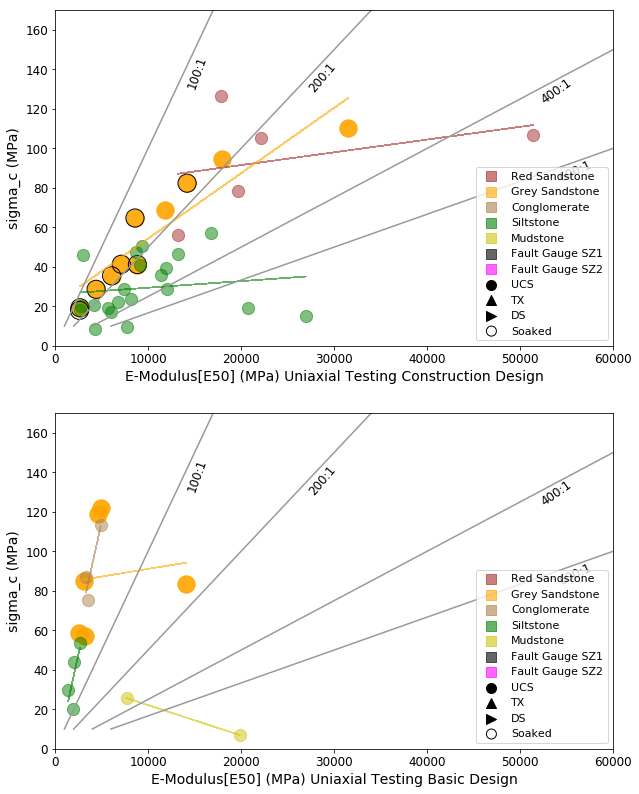

In [58]:
# scatterplot of E50 against sigma_c for all rock lithologies
# input: scatterplot_data_df

# lithologies: defined above 
E={}
sigma_c={}
marker={}

# select E, sgima_c data pairs and write to dictionary
def selected_pairs(sample_description):
    E.clear()
    sigma_c.clear()
    for lithology in lithologies:
        E[lithology]=[]  #initialize dictionary
        sigma_c[lithology]=[]  #initialize dictionary
        marker[lithology]=[]  #initialize dictionary
    for i in range(len(scatterplot_data_df)):
        if (scatterplot_data_df['value_x'][i]) != 'NaN':  #ignore NaN values    
            if (scatterplot_data_df['sample_description'][i]) == sample_description:  #select for phase
                for lithology in lithologies:  # select for lithology
                    if (scatterplot_data_df['lithology'][i]) == lithology:
                        if float(scatterplot_data_df['value_x'][i]):  #this is only check for E, not sigma_c         #ToDo JK
                            E[lithology].append(float(scatterplot_data_df['value_x'][i]))
                            sigma_c[lithology].append(float(scatterplot_data_df['value_y'][i]))
                            if (scatterplot_data_df['sample_state_y'][i]): 
                                marker[lithology].append(scatterplot_data_df['sample_state_y'][i])
                            else:
                                marker[lithology].append('NaN')

# def scatter_plot(E_, sigma_c_, lithology, sample_description):
#     if E_.any():  # if E values are present for a selected lithology
        
#         # scatterplot for values of selected lithology
#         plt.scatter(E_,sigma_c_,
#                     marker='o',s= 150.,facecolor=colors[lithology],alpha=0.5)
                
#         #calculate linear regression
#         line=(); s1=(); s3=(); intercept=0.; slope=0.; std_err=0.
#         slope, intercept, r_value, p_value, std_err = stats.linregress(E_,sigma_c_)
#         line = slope*E_+intercept
#         plt.plot(E_,line, color=colors[lithology],alpha=0.6,linewidth=0.8,antialiased=False)
#         print(sample_description+'  '+lithology+'  '+
#               'intercept: '+str(intercept)+'  slope: '+str(slope)+'  error: '+str(std_err))

# highlight Grey Sandstone in plot (size s, alpha) to avoid being hidden by Siltstones
def scatter_plot(E_, sigma_c_, lithology, sample_description):
    if E_.any():  # if E values are present for a selected lithology
        
        # scatterplot for values of selected lithology
        if lithology == 'Grey Sandstone':
            plt.scatter(E_,sigma_c_,
                    marker='o',s= 300.,facecolor=colors[lithology],alpha=0.9)
        else: 
            plt.scatter(E_,sigma_c_,
                    marker='o',s= 150.,facecolor=colors[lithology],alpha=0.5)

        #calculate linear regression
        line=(); s1=(); s3=(); intercept=0.; slope=0.; std_err=0.
        slope, intercept, r_value, p_value, std_err = stats.linregress(E_,sigma_c_)
        line = slope*E_+intercept
        plt.plot(E_,line, color=colors[lithology],alpha=0.6,linewidth=0.8,antialiased=False)
        print(sample_description+'  '+lithology+'  '+
              'intercept: '+str(intercept)+'  slope: '+str(slope)+'  error: '+str(std_err))

        # plot markers showing sample_state (e.g. 'Soaked')        
def plot_marker(marker, E_, sigma_c_, lithology):
    print(lithology)
    for i in range(len(marker)):
        if (marker[i]) == 'Soaked':
            plt.scatter(E_[i],sigma_c_[i],
                    marker='o',s= 330.,edgecolor='black',facecolor='',alpha=1.0)
            print(marker[i],E_[i],sigma_c_[i])
                
def legend():    
# legend
# location [-10], [-10] is a quick hack, replace with something more conventional
    sym1 = plt.scatter([-10], [-10], marker="s", alpha=0.6, s=100, color="brown")
    sym2 = plt.scatter([-10], [-10], marker="s", alpha=0.6, s=100, color="orange")
    sym3 = plt.scatter([-10], [-10], marker="s", alpha=0.6, s=100, color="#ad8150")
    sym4 = plt.scatter([-10], [-10], marker="s", alpha=0.6, s=100, color="green")
    sym5 = plt.scatter([-10], [-10], marker="s", alpha=0.6, s=100, color="#cdc50a")
    sym6 = plt.scatter([-10], [-10], marker="s", alpha=0.6, s=100, color="black")
    sym7 = plt.scatter([-10], [-10], marker="s", alpha=0.6, s=100, color="magenta")
    sym10 = plt.scatter([-10], [-10], marker="o", alpha=1.0, s=100, color="black")
    sym11 = plt.scatter([-10], [-10], marker="^", alpha=1.0, s=100, color="black")
    sym12 = plt.scatter([-10], [-10], marker=">", alpha=1.0, s=100, color="black")
    sym13 = plt.scatter([-10], [-10], marker="o", alpha=1.0, s=100, color='black', 
                   facecolor='')
    plt.legend((sym1,sym2,sym3,sym4,sym5,sym6,sym7,sym10,sym11,sym12,sym13),
           ("Red Sandstone","Grey Sandstone","Conglomerate","Siltstone","Mudstone","Fault Gauge SZ1","Fault Gauge SZ2",
            "UCS","TX","DS", "Soaked"),
             fontsize=11, numpoints=1,loc="lower right")
    
def trend():
# show a reference trend line
    plt.plot((1000,10000,20000,30000),(10,100,200,300),color='0.6')
    plt.annotate("100:1",xy=(14000,143),xytext=(14000,143),rotation=70,fontsize=12)
    plt.plot((2000,20000,40000,60000),(10,100,200,300),color='0.6')
    plt.annotate("200:1",xy=(27000,140),xytext=(27000,140),rotation=50,fontsize=12)
    plt.plot((4000,40000,60000),(10,100,150),color='0.6')
    plt.annotate("400:1",xy=(52000,132),xytext=(52000,132),rotation=35,fontsize=12)
    plt.plot((6000,60000),(10,100),color='0.6')
    plt.annotate("600:1",xy=(54000,90),xytext=(54000,90),rotation=25,fontsize=12)


plt.figure(figsize=(10, 21))

plt.subplot(311)
selected_pairs('Construction Design')
for lithology in lithologies:
    scatter_plot(np.array(E[lithology]),np.array(sigma_c[lithology]),lithology,'Construction Design')
    plot_marker(np.array(marker[lithology]),np.array(E[lithology]),np.array(sigma_c[lithology]),lithology)
plt.xlim((0,60000))
plt.ylim((0,170))
plt.ylabel('sigma_c (MPa)',fontsize=14)
plt.xlabel('E-Modulus[E50] (MPa) Uniaxial Testing Construction Design',fontsize=14)
trend()
legend()

plt.subplot(312)
selected_pairs('Basic Design')
for lithology in lithologies:
    scatter_plot(np.array(E[lithology]),np.array(sigma_c[lithology]),lithology,'Basic Design')
    plot_marker(np.array(marker[lithology]), np.array(E[lithology]),np.array(sigma_c[lithology]),lithology)
plt.xlim((0,60000))
plt.ylim((0,170))
plt.ylabel('sigma_c (MPa)',fontsize=14)
plt.xlabel('E-Modulus[E50] (MPa) Uniaxial Testing Basic Design',fontsize=14)
trend()
legend()

plt.show()

## Scatterplot of triaxial testing data E50 vs sigma_c

In [59]:
# filter test records for triaxial compression
# input: data_E, data_sigma_c

data_sigma_c_adj=[]  # adjusted lists containing uniaxial testing records
data_E_adj=[]
##data_sigma_c_adj_loc=[] # adjusted lists containing borehole/sample_depth locations
##data_E_adj_loc=[]

for item in data_sigma_c:
    if item['test_type'] == 'Triaxial compression':
        data_sigma_c_adj.append(item)
        ##data_sigma_c_adj_loc.append((item['borehole_code'],item['sample_depth_top_m']))
for item in data_E:
    if item['test_type'] == 'E measured during triaxial compression':
        data_E_adj.append(item)
        ##data_E_adj_loc.append((item['borehole_code'],item['sample_depth_top_m']))
        
# check record counts
print(len(data_sigma_c))
print(len(data_sigma_c_adj))
print(len(data_E))
print(len(data_E_adj))
# more checking
#pd.DataFrame(data=data_E_adj)
#pd.DataFrame(data=data_sigma_c_adj)

92
35
80
29


In [60]:
pd.DataFrame(data=data_E_adj)

,borehole_code,lithology,measurement_convention,sample_code,sample_depth_top_m,sample_description,sample_state,test_parameters,test_type,value,value_unit
0,NT1-15,Siltstone,E50,11,31.90,Construction Design,,1.00,E measured during triaxial compression,6830.00,MPa
1,NT1-15,Siltstone,E50,12,31.90,Construction Design,,3.00,E measured during triaxial compression,8770.00,MPa
2,NT1-15,Siltstone,E50,21,32.20,Construction Design,,5.00,E measured during triaxial compression,7940.00,MPa
3,NT1-15,Siltstone,E50,31,36.08,Construction Design,,1.00,E measured during triaxial compression,6867.00,MPa
4,NT1-15,Siltstone,E50,33,36.08,Construction Design,,5.00,E measured during triaxial compression,9579.00,MPa
5,NT1-15,Siltstone,E50,32,36.08,Construction Design,,3.00,E measured during triaxial compression,11800.00,MPa
6,NT1-18,Siltstone,E50,12,25.87,Construction Design,,5.00,E measured during triaxial compression,4130.00,MPa
7,NT1-18,Siltstone,E50,11,25.87,Construction Design,,3.00,E measured during triaxial compression,3710.00,MPa
8,NT1-19,Siltstone,E50,12,58.60,Construction Design,,3.00,E measured during triaxial compression,8674.00,MPa
9,NT1-19,Siltstone,E50,11,58.60,Construction Design,,1.00,E measured during triaxial compression,11660.00,MPa


In [61]:
pd.DataFrame(data=data_sigma_c_adj)

,borehole_code,lithology,sample_code,sample_depth_top_m,sample_description,sample_state,test_parameters,test_type,value,value_unit
0,NT1-14,Red Sandstone,11,28.90,Construction Design,,1.00,Triaxial compression,90.54,MPa
1,NT1-14,Red Sandstone,13,28.90,Construction Design,,5.00,Triaxial compression,128.55,MPa
2,NT1-14,Red Sandstone,12,28.90,Construction Design,,3.00,Triaxial compression,127.17,MPa
3,NT1-14,Red Sandstone,22,57.85,Construction Design,,3.00,Triaxial compression,87.08,MPa
4,NT1-14,Red Sandstone,23,57.85,Construction Design,,5.00,Triaxial compression,106.43,MPa
5,NT1-14,Red Sandstone,21,57.85,Construction Design,,1.00,Triaxial compression,63.58,MPa
6,NT1-15,Siltstone,12,31.90,Construction Design,,3.00,Triaxial compression,65.70,MPa
7,NT1-15,Siltstone,11,31.90,Construction Design,,1.00,Triaxial compression,45.61,MPa
8,NT1-15,Siltstone,21,32.20,Construction Design,,5.00,Triaxial compression,63.38,MPa
9,NT1-15,Siltstone,31,36.08,Construction Design,,1.00,Triaxial compression,52.53,MPa


In [62]:
# create dataframes of test data filtered for triaxial compression 
data_E_adj_df = pd.DataFrame(data=data_E_adj)
data_sigma_c_adj_df = pd.DataFrame(data=data_sigma_c_adj)

# merge dataframes of filtered test data keying on borehole and sample parameters
#   df merge example
#     result = pd.merge(left, right, on=['key1', 'key2'])
#     http://pandas.pydata.org/pandas-docs/stable/merging.html#database-style-dataframe-joining-merging
scatterplot_data_df = pd.merge(data_E_adj_df, data_sigma_c_adj_df, 
                               on=['borehole_code', 'sample_depth_top_m', 'sample_code',
                                   'lithology', 'sample_description', 'test_parameters'])

scatterplot_data_df

,borehole_code,lithology,measurement_convention,sample_code,sample_depth_top_m,sample_description,sample_state_x,test_parameters,test_type_x,value_x,value_unit_x,sample_state_y,test_type_y,value_y,value_unit_y
0,NT1-15,Siltstone,E50,11,31.90,Construction Design,,1.00,E measured during triaxial compression,6830.00,MPa,,Triaxial compression,45.61,MPa
1,NT1-15,Siltstone,E50,12,31.90,Construction Design,,3.00,E measured during triaxial compression,8770.00,MPa,,Triaxial compression,65.70,MPa
2,NT1-15,Siltstone,E50,21,32.20,Construction Design,,5.00,E measured during triaxial compression,7940.00,MPa,,Triaxial compression,63.38,MPa
3,NT1-15,Siltstone,E50,31,36.08,Construction Design,,1.00,E measured during triaxial compression,6867.00,MPa,,Triaxial compression,52.53,MPa
4,NT1-15,Siltstone,E50,33,36.08,Construction Design,,5.00,E measured during triaxial compression,9579.00,MPa,,Triaxial compression,80.17,MPa
5,NT1-15,Siltstone,E50,32,36.08,Construction Design,,3.00,E measured during triaxial compression,11800.00,MPa,,Triaxial compression,74.64,MPa
6,NT1-18,Siltstone,E50,12,25.87,Construction Design,,5.00,E measured during triaxial compression,4130.00,MPa,,Triaxial compression,59.09,MPa
7,NT1-18,Siltstone,E50,11,25.87,Construction Design,,3.00,E measured during triaxial compression,3710.00,MPa,,Triaxial compression,42.14,MPa
8,NT1-19,Siltstone,E50,12,58.60,Construction Design,,3.00,E measured during triaxial compression,8674.00,MPa,,Triaxial compression,58.06,MPa
9,NT1-19,Siltstone,E50,11,58.60,Construction Design,,1.00,E measured during triaxial compression,11660.00,MPa,,Triaxial compression,59.00,MPa


Red Sandstone
Grey Sandstone
Construction Design  Siltstone  intercept: 37.47322278021812  slope: 0.002812119267711824  error: 0.0009984454681072309
Siltstone
Conglomerate
Mudstone
Fault Gauge SZ1
Fault Gauge SZ2
Red Sandstone
Basic Design  Grey Sandstone  intercept: -60.162639429748154  slope: 0.045462252015543686  error: 0.00737331762650523
Grey Sandstone
Basic Design  Siltstone  intercept: 2.951370967741937  slope: 0.01179897718332022  error: 0.004180970642085691
Siltstone
Conglomerate
Mudstone
Fault Gauge SZ1
Fault Gauge SZ2


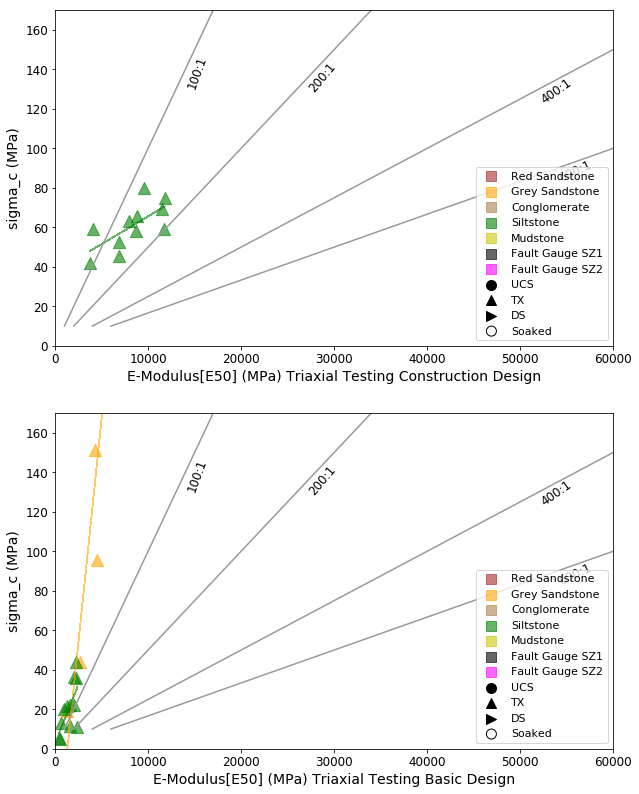

In [63]:
# scatterplot of E50 against sigma_c for all rock lithologies
# input: scatterplot_data_df

# lithologies: defined above 
E={}
sigma_c={}
marker={}

# # select E, sgima_c data pairs and write to dictionary
# def selected_pairs(sample_description):
#     E.clear()
#     sigma_c.clear()
#     for lithology in lithologies:
#         E[lithology]=[]  #initialize dictionary
#         sigma_c[lithology]=[]  #initialize dictionary
#         marker[lithology]=[]  #initialize dictionary
#     for i in range(len(scatterplot_data_df)):
#         if (scatterplot_data_df['value_x'][i]) != 'NaN':  #ignore NaN values    
#             if (scatterplot_data_df['sample_description'][i]) == sample_description:  #select for phase
#                 for lithology in lithologies:  # select for lithology
#                     if (scatterplot_data_df['lithology'][i]) == lithology:
#                         if float(scatterplot_data_df['value_x'][i]):  #this is only check for E, not sigma_c         #ToDo JK
#                             E[lithology].append(float(scatterplot_data_df['value_x'][i]))
#                             sigma_c[lithology].append(float(scatterplot_data_df['value_y'][i]))
#                             if (scatterplot_data_df['sample_state_y'][i]): 
#                                 marker[lithology].append(scatterplot_data_df['sample_state_y'][i])
#                             else:
#                                 marker[lithology].append('NaN')

def scatter_plot(E_, sigma_c_, lithology, sample_description):
    if E_.any():  # if E values are present for a selected lithology
        
        # scatterplot for values of selected lithology
        plt.scatter(E_,sigma_c_,
                    marker='^',s= 150.,facecolor=colors[lithology],alpha=0.6)
                
        #calculate linear regression
        line=(); s1=(); s3=(); intercept=0.; slope=0.; std_err=0.
        slope, intercept, r_value, p_value, std_err = stats.linregress(E_,sigma_c_)
        line = slope*E_+intercept
        plt.plot(E_,line, color=colors[lithology],alpha=0.6,linewidth=0.8,antialiased=False)
        print(sample_description+'  '+lithology+'  '+
              'intercept: '+str(intercept)+'  slope: '+str(slope)+'  error: '+str(std_err))

# # plot markers showing sample_state (e.g. 'Soaked')        
# def plot_marker(marker, E_, sigma_c_, lithology):
#     print(lithology)
#     for i in range(len(marker)):
#         if (marker[i]) == 'Soaked':
#             plt.scatter(E_[i],sigma_c_[i],
#                     marker='o',s= 150.,edgecolor='black',facecolor='',alpha=1.0)
#             print(marker[i],E_[i],sigma_c_[i])
                
# def legend():    
# # legend
# # location [-10], [-10] is a quick hack, replace with something more conventional
#     sym1 = plt.scatter([-10], [-10], marker="^", alpha=1.0, s=100, color="red")
#     sym2 = plt.scatter([-10], [-10], marker="^", alpha=1.0, s=100, color="orange")
#     sym3 = plt.scatter([-10], [-10], marker="^", alpha=1.0, s=100, color="brown")
#     sym4 = plt.scatter([-10], [-10], marker="^", alpha=1.0, s=100, color="green")
#     sym5 = plt.scatter([-10], [-10], marker="^", alpha=1.0, s=100, color="yellow")
#     sym6 = plt.scatter([-10], [-10], marker="^", alpha=1.0, s=100, color="black")
#     sym7 = plt.scatter([-10], [-10], marker="^", alpha=1.0, s=100, color="magenta")
#     sym9 = plt.scatter([-10], [-10], marker="o", alpha=1.0, s=100, color='black', 
#                    facecolor='')
#     plt.legend((sym1,sym2,sym3,sym4,sym5,sym6,sym7,sym9),
#            ("Red Sandstone","Grey Sandstone","Conglomerate","Siltstone","Mudstone","Fault Gauge SZ1","Fault Gauge SZ2",
#             "Soaked"),
#              fontsize=11, numpoints=1,loc="lower right")
    
# def trend():
# # show a reference trend line
#     plt.plot((1000,10000,20000,30000),(10,100,200,300),color='0.6')
#     plt.annotate("100:1",xy=(14000,143),xytext=(14000,143),rotation=70,fontsize=12)
#     plt.plot((2000,20000,40000,60000),(10,100,200,300),color='0.6')
#     plt.annotate("200:1",xy=(27000,140),xytext=(27000,140),rotation=50,fontsize=12)
#     plt.plot((4000,40000,60000),(10,100,150),color='0.6')
#     plt.annotate("400:1",xy=(52000,132),xytext=(52000,132),rotation=35,fontsize=12)
#     plt.plot((6000,60000),(10,100),color='0.6')
#     plt.annotate("600:1",xy=(54000,90),xytext=(54000,90),rotation=25,fontsize=12)


plt.figure(figsize=(10, 21))

plt.subplot(311)
selected_pairs('Construction Design')
for lithology in lithologies:
    scatter_plot(np.array(E[lithology]),np.array(sigma_c[lithology]),lithology,'Construction Design')
    plot_marker(np.array(marker[lithology]), np.array(E[lithology]),np.array(sigma_c[lithology]),lithology)
plt.xlim((0,60000))
plt.ylim((0,170))
plt.ylabel('sigma_c (MPa)',fontsize=14)
plt.xlabel('E-Modulus[E50] (MPa) Triaxial Testing Construction Design',fontsize=14)
trend()
legend()

plt.subplot(312)
selected_pairs('Basic Design')
for lithology in lithologies:
    scatter_plot(np.array(E[lithology]),np.array(sigma_c[lithology]),lithology,'Basic Design')
    plot_marker(np.array(marker[lithology]), np.array(E[lithology]),np.array(sigma_c[lithology]),lithology)
plt.xlim((0,60000))
plt.ylim((0,170))
plt.ylabel('sigma_c (MPa)',fontsize=14)
plt.xlabel('E-Modulus[E50] (MPa) Triaxial Testing Basic Design',fontsize=14)
trend()
legend()

plt.show()